### Necessary Imports

In [6]:
import os
import sys
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'cnn')))
from cnn import CNN
from multilabel_cnn import MultiLabelCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Single Label Classification using CNNs
### Implementation a function load mnist data()

In [10]:
def load_mnist_data(base_path='../../data/interim/4/double_mnist', use_label_count=False):
    images = {
        'train': [],
        'val': [],
        'test': []
    }
    labels = {
        'train': [],
        'val': [],
        'test': []
    }

    splits = ['train', 'val', 'test']
    for split in splits:
        split_path = os.path.join(base_path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    img_path = os.path.join(label_path, img_name)
                    img = Image.open(img_path).convert('L')
                    img_array = np.array(img)
                    images[split].append(img_array)

                    if use_label_count:
                        if label == "0":
                            label_count = 0
                        else:
                            label_count = len(label)
                        labels[split].append(label_count)
                    else:
                        labels[split].append(one_hot_encode_label(label))

    return images, labels

images, labels = load_mnist_data(use_label_count=True)


The `images` and `labels` variables are dictionaries containing lists for three data splits: 'train', 'val', and 'test'. Each list holds arrays of image data for `images`, and corresponding label counts or one-hot encoded labels for `labels`, depending on the `use_label_count` flag.

### MultiMNISTDataset Class to create dataloaders for training and evaluation purposes.

In [12]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        img = torch.tensor(img, dtype=torch.float32) / 255.0  

        if self.transform:
            img = self.transform(img)

        return img, label

transform = transforms.Compose([
    transforms.ToPILImage(),         
    transforms.Resize((28, 28)),     
    transforms.ToTensor(),         
])

train_dataset = MultiMNISTDataset(images['train'], labels['train'], transform=transform)
val_dataset = MultiMNISTDataset(images['val'], labels['val'], transform=transform)
test_dataset = MultiMNISTDataset(images['test'], labels['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Running the CNN Class for Classifiction and Regression

It accepts a `task` parameter to differentiate between classification and regression, defines convolutional layers and activation functions in its architecture, and has a `forward()` method that processes input data according to the selected task, handling output requirements appropriately.

In [5]:
model = CNN(task='regression', loss_figure_save_path='./figures/cnn_loss_plots/regression_demo.png').to(device)
model.fit(train_loader, val_loader, epochs= 4)

./figures/cnn_loss_plots/regression_demo.png


Training Epoch 1/4: 100%|██████████| 394/394 [00:16<00:00, 23.91it/s]


Epoch [1/4], Training Loss: 0.1556, Validation Loss: 0.0130


Training Epoch 2/4: 100%|██████████| 394/394 [00:17<00:00, 22.62it/s]


Epoch [2/4], Training Loss: 0.0133, Validation Loss: 0.0069


Training Epoch 3/4: 100%|██████████| 394/394 [00:19<00:00, 20.37it/s]


Epoch [3/4], Training Loss: 0.0063, Validation Loss: 0.0047


Training Epoch 4/4: 100%|██████████| 394/394 [00:16<00:00, 23.85it/s]


Epoch [4/4], Training Loss: 0.0058, Validation Loss: 0.0040


![Regression](figures/cnn_loss_plots/regression_demo.png)

In [7]:
model = CNN(task='classification', num_conv_layers=3,dropout_rate=0.2, optimizer_choice='adam', device=device, loss_figure_save_path='./figures/cnn_loss_plots/classification_demo.png').to(device)
model.fit(train_loader, val_loader, epochs=4)

./figures/cnn_loss_plots/classification_demo.png


Training Epoch 1/4: 100%|██████████| 394/394 [00:15<00:00, 25.65it/s]


Epoch [1/4], Training Loss: 0.2531, Validation Loss: 0.0031


Training Epoch 2/4: 100%|██████████| 394/394 [00:15<00:00, 25.45it/s]


Epoch [2/4], Training Loss: 0.0039, Validation Loss: 0.0004


Training Epoch 3/4: 100%|██████████| 394/394 [00:14<00:00, 27.66it/s]


Epoch [3/4], Training Loss: 0.0151, Validation Loss: 0.0008


Training Epoch 4/4: 100%|██████████| 394/394 [00:16<00:00, 24.55it/s]


Epoch [4/4], Training Loss: 0.0012, Validation Loss: 0.0001


![Classification](figures/cnn_loss_plots/classification_demo.png)

In [ ]:
import pandas as pd
import torch

def calculate_accuracy_cnn(model, test_loader, output_file='demo_classification_predictions.csv', save_to_file=False):
    model.eval()
    predictions = model.predict(test_loader)
    
    true_labels = []
    for _, labels in test_loader:
        true_labels.append(labels)
    true_labels = torch.cat(true_labels).cpu()
    predictions = torch.round(predictions).cpu()

    results_df = pd.DataFrame({
        'True Labels': true_labels.numpy(),
        'Predictions': predictions.numpy(),
        'Correctness': ['✓' if true == pred else 'x' for true, pred in zip(true_labels.numpy(), predictions.numpy())]
    })

    if save_to_file:
        results_df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")

    correct_predictions = (true_labels == predictions).sum().item()
    total_predictions = true_labels.size(0)
    accuracy = correct_predictions / total_predictions

    print(f"Accuracy: {accuracy:.4f}")

calculate_accuracy_cnn(model, val_loader, save_to_file=True)


### Hyperparameter Tuning

The key hyperparameters to tune are: `lr`, `dropout_rate`, `num_conv_layers`, `optimizer_choice`, `num_epochs` and `activation_function`.

Early stopping may also have been tuned giving us a much larger search space

In [18]:
import os
import json
import torch.nn as nn
import torch

hyperparam_combinations = [
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 5},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'tanh', 'epochs': 5},
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 10},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 3, 'optimizer_choice': 'sgd', 'activation_function': 'tanh', 'epochs': 10},
    {'lr': 0.0005, 'dropout_rate': 0.2, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 5},
    {'lr': 0.0005, 'dropout_rate': 0.4, 'num_conv_layers': 2, 'optimizer_choice': 'sgd', 'activation_function': 'tanh', 'epochs': 5},
    {'lr': 0.0005, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 5},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 3, 'optimizer_choice': 'sgd', 'activation_function': 'relu', 'epochs': 10}
]



plot_save_dir = "./figures/cnn_loss_plots"
os.makedirs(plot_save_dir, exist_ok=True)

best_classification_model, best_classification_loss, best_classification_combination = None, float('inf'), None
best_regression_model, best_regression_loss, best_regression_combination = None, float('inf'), None

for task in ['classification', 'regression']:
    for idx, params in enumerate(hyperparam_combinations, 1):
        print(f"\n{task.capitalize()} CNN for {params['epochs']} epochs with learning rate = {params['lr']}, Dropout = {params['dropout_rate']}, {params['num_conv_layers']} convolutional layers, {params['activation_function']} activation and {params['optimizer_choice']} optimizer")
        loss_figure_save_path = os.path.join(
            plot_save_dir,
            f"{task}_loss_combination_{idx}_lr_{params['lr']}_dropout_{params['dropout_rate']}_layers_{params['num_conv_layers']}_activ_{params['activation_function']}_opt_{params['optimizer_choice']}.png"
        )
        model = CNN(
            task=task,
            num_classes=4 if task == 'classification' else 1,
            num_conv_layers=params['num_conv_layers'],
            dropout_rate=params['dropout_rate'],
            optimizer_choice=params['optimizer_choice'],
            activation_function=params['activation_function'],
            device=device,
            loss_figure_save_path = loss_figure_save_path
        )

        model.fit(train_loader, val_loader, epochs=params['epochs'], lr=params['lr'])
        
        criterion = nn.CrossEntropyLoss() if task == 'classification' else nn.MSELoss()
        val_loss = model.evaluate(val_loader, criterion=criterion)
        print("\nAccuracy on Validation Set")
        calculate_accuracy_cnn(model, val_loader)
        
        if task == 'classification':
            if val_loss < best_classification_loss:
                best_classification_model = model
                best_classification_loss = val_loss
                best_classification_combination = params
        else:  # task == 'regression'
            if val_loss < best_regression_loss:
                best_regression_model = model
                best_regression_loss = val_loss
                best_regression_combination = params

best_params = {
    "best_classification_combination": best_classification_combination,
    "best_regression_combination": best_regression_combination
}

params_file_path = os.path.join(plot_save_dir, "best_model_params.json")
with open(params_file_path, 'w') as json_file:
    json.dump(best_params, json_file, indent=4)

print("Best Classification Model Combination:", best_classification_combination)
print("Best Regression Model Combination:", best_regression_combination)
print(f"Best parameters saved to {params_file_path}")


Classification CNN for 5 epochs with learning rate = 0.001, Dropout = 0.2, 2 convolutional layers, relu activation and adam optimizer
./figures/cnn_loss_plots/classification_loss_combination_1_lr_0.001_dropout_0.2_layers_2_activ_relu_opt_adam.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:09<00:00, 41.38it/s]


Epoch [1/5], Training Loss: 0.2386, Validation Loss: 0.0089


Training Epoch 2/5: 100%|██████████| 394/394 [00:08<00:00, 46.84it/s]


Epoch [2/5], Training Loss: 0.0074, Validation Loss: 0.0012


Training Epoch 3/5: 100%|██████████| 394/394 [00:09<00:00, 43.52it/s]


Epoch [3/5], Training Loss: 0.0051, Validation Loss: 0.0041


Training Epoch 4/5: 100%|██████████| 394/394 [00:11<00:00, 35.37it/s]


Epoch [4/5], Training Loss: 0.0139, Validation Loss: 0.0007


Training Epoch 5/5: 100%|██████████| 394/394 [00:12<00:00, 32.56it/s]


Epoch [5/5], Training Loss: 0.0009, Validation Loss: 0.0002

Accuracy on Validation Set
Accuracy: 1.0000

Classification CNN for 5 epochs with learning rate = 0.001, Dropout = 0.4, 2 convolutional layers, tanh activation and adam optimizer
./figures/cnn_loss_plots/classification_loss_combination_2_lr_0.001_dropout_0.4_layers_2_activ_tanh_opt_adam.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:11<00:00, 34.84it/s]


Epoch [1/5], Training Loss: 0.1942, Validation Loss: 0.0073


Training Epoch 2/5: 100%|██████████| 394/394 [00:11<00:00, 35.49it/s]


Epoch [2/5], Training Loss: 0.0230, Validation Loss: 0.0013


Training Epoch 3/5: 100%|██████████| 394/394 [00:12<00:00, 30.41it/s]


Epoch [3/5], Training Loss: 0.0097, Validation Loss: 0.0001


Training Epoch 4/5: 100%|██████████| 394/394 [00:13<00:00, 29.85it/s]


Epoch [4/5], Training Loss: 0.0032, Validation Loss: 0.0002


Training Epoch 5/5: 100%|██████████| 394/394 [00:12<00:00, 30.60it/s]


Epoch [5/5], Training Loss: 0.0237, Validation Loss: 0.0006

Accuracy on Validation Set
Accuracy: 1.0000

Classification CNN for 10 epochs with learning rate = 0.001, Dropout = 0.2, 3 convolutional layers, relu activation and adam optimizer
./figures/cnn_loss_plots/classification_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:11<00:00, 35.76it/s]


Epoch [1/10], Training Loss: 0.2269, Validation Loss: 0.0032


Training Epoch 2/10: 100%|██████████| 394/394 [00:11<00:00, 35.46it/s]


Epoch [2/10], Training Loss: 0.0047, Validation Loss: 0.0003


Training Epoch 3/10: 100%|██████████| 394/394 [00:13<00:00, 28.60it/s]


Epoch [3/10], Training Loss: 0.0264, Validation Loss: 0.0040


Training Epoch 4/10: 100%|██████████| 394/394 [00:11<00:00, 35.25it/s]


Epoch [4/10], Training Loss: 0.0011, Validation Loss: 0.0002


Training Epoch 5/10: 100%|██████████| 394/394 [00:11<00:00, 34.99it/s]


Epoch [5/10], Training Loss: 0.0009, Validation Loss: 0.0001


Training Epoch 6/10: 100%|██████████| 394/394 [00:13<00:00, 29.03it/s]


Epoch [6/10], Training Loss: 0.0003, Validation Loss: 0.0000


Training Epoch 7/10: 100%|██████████| 394/394 [00:12<00:00, 31.65it/s]


Epoch [7/10], Training Loss: 0.0002, Validation Loss: 0.0000


Training Epoch 8/10: 100%|██████████| 394/394 [00:13<00:00, 28.93it/s]


Epoch [8/10], Training Loss: 0.0001, Validation Loss: 0.0000


Training Epoch 9/10: 100%|██████████| 394/394 [00:15<00:00, 25.05it/s]


Epoch [9/10], Training Loss: 0.0001, Validation Loss: 0.0000


Training Epoch 10/10: 100%|██████████| 394/394 [00:16<00:00, 24.48it/s]


Epoch [10/10], Training Loss: 0.0000, Validation Loss: 0.0000

Accuracy on Validation Set
Accuracy: 1.0000

Classification CNN for 10 epochs with learning rate = 0.001, Dropout = 0.4, 3 convolutional layers, tanh activation and sgd optimizer
./figures/cnn_loss_plots/classification_loss_combination_4_lr_0.001_dropout_0.4_layers_3_activ_tanh_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:14<00:00, 27.48it/s]


Epoch [1/10], Training Loss: 1.1710, Validation Loss: 1.1015


Training Epoch 2/10: 100%|██████████| 394/394 [00:14<00:00, 27.55it/s]


Epoch [2/10], Training Loss: 1.1382, Validation Loss: 1.0857


Training Epoch 3/10: 100%|██████████| 394/394 [00:14<00:00, 28.09it/s]


Epoch [3/10], Training Loss: 1.0960, Validation Loss: 0.9791


Training Epoch 4/10: 100%|██████████| 394/394 [00:12<00:00, 30.49it/s]


Epoch [4/10], Training Loss: 0.7676, Validation Loss: 0.4226


Training Epoch 5/10: 100%|██████████| 394/394 [00:13<00:00, 28.55it/s]


Epoch [5/10], Training Loss: 0.3211, Validation Loss: 0.1413


Training Epoch 6/10: 100%|██████████| 394/394 [00:11<00:00, 34.19it/s]


Epoch [6/10], Training Loss: 0.1120, Validation Loss: 0.0546


Training Epoch 7/10: 100%|██████████| 394/394 [00:12<00:00, 30.78it/s]


Epoch [7/10], Training Loss: 0.0567, Validation Loss: 0.0305


Training Epoch 8/10: 100%|██████████| 394/394 [00:12<00:00, 30.52it/s]


Epoch [8/10], Training Loss: 0.0348, Validation Loss: 0.0215


Training Epoch 9/10: 100%|██████████| 394/394 [00:14<00:00, 27.74it/s]


Epoch [9/10], Training Loss: 0.0246, Validation Loss: 0.0151


Training Epoch 10/10: 100%|██████████| 394/394 [00:12<00:00, 31.01it/s]


Epoch [10/10], Training Loss: 0.0186, Validation Loss: 0.0105

Accuracy on Validation Set
Accuracy: 0.9997

Classification CNN for 5 epochs with learning rate = 0.0005, Dropout = 0.2, 2 convolutional layers, relu activation and adam optimizer
./figures/cnn_loss_plots/classification_loss_combination_5_lr_0.0005_dropout_0.2_layers_2_activ_relu_opt_adam.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:12<00:00, 31.78it/s]


Epoch [1/5], Training Loss: 0.3439, Validation Loss: 0.0421


Training Epoch 2/5: 100%|██████████| 394/394 [00:11<00:00, 34.08it/s]


Epoch [2/5], Training Loss: 0.0257, Validation Loss: 0.0066


Training Epoch 3/5: 100%|██████████| 394/394 [00:12<00:00, 32.60it/s]


Epoch [3/5], Training Loss: 0.0100, Validation Loss: 0.0031


Training Epoch 4/5: 100%|██████████| 394/394 [00:12<00:00, 32.48it/s]


Epoch [4/5], Training Loss: 0.0037, Validation Loss: 0.0015


Training Epoch 5/5: 100%|██████████| 394/394 [00:11<00:00, 35.74it/s]


Epoch [5/5], Training Loss: 0.0016, Validation Loss: 0.0017

Accuracy on Validation Set
Accuracy: 0.9997

Classification CNN for 5 epochs with learning rate = 0.0005, Dropout = 0.4, 2 convolutional layers, tanh activation and sgd optimizer
./figures/cnn_loss_plots/classification_loss_combination_6_lr_0.0005_dropout_0.4_layers_2_activ_tanh_opt_sgd.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:11<00:00, 33.16it/s]


Epoch [1/5], Training Loss: 1.1529, Validation Loss: 1.0859


Training Epoch 2/5: 100%|██████████| 394/394 [00:14<00:00, 27.98it/s]


Epoch [2/5], Training Loss: 1.1171, Validation Loss: 1.0536


Training Epoch 3/5: 100%|██████████| 394/394 [00:11<00:00, 34.98it/s]


Epoch [3/5], Training Loss: 1.0663, Validation Loss: 0.9637


Training Epoch 4/5: 100%|██████████| 394/394 [00:09<00:00, 39.85it/s]


Epoch [4/5], Training Loss: 0.8846, Validation Loss: 0.6484


Training Epoch 5/5: 100%|██████████| 394/394 [00:11<00:00, 35.14it/s]


Epoch [5/5], Training Loss: 0.5343, Validation Loss: 0.3291

Accuracy on Validation Set
Accuracy: 0.9393

Classification CNN for 5 epochs with learning rate = 0.0005, Dropout = 0.2, 3 convolutional layers, relu activation and adam optimizer
./figures/cnn_loss_plots/classification_loss_combination_7_lr_0.0005_dropout_0.2_layers_3_activ_relu_opt_adam.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:11<00:00, 33.41it/s]


Epoch [1/5], Training Loss: 0.3340, Validation Loss: 0.0164


Training Epoch 2/5: 100%|██████████| 394/394 [00:13<00:00, 30.29it/s]


Epoch [2/5], Training Loss: 0.0103, Validation Loss: 0.0023


Training Epoch 3/5: 100%|██████████| 394/394 [00:12<00:00, 30.88it/s]


Epoch [3/5], Training Loss: 0.0021, Validation Loss: 0.0010


Training Epoch 4/5: 100%|██████████| 394/394 [00:12<00:00, 32.52it/s]


Epoch [4/5], Training Loss: 0.0048, Validation Loss: 0.0004


Training Epoch 5/5: 100%|██████████| 394/394 [00:12<00:00, 31.61it/s]


Epoch [5/5], Training Loss: 0.0009, Validation Loss: 0.0001

Accuracy on Validation Set
Accuracy: 1.0000

Classification CNN for 10 epochs with learning rate = 0.001, Dropout = 0.4, 3 convolutional layers, relu activation and sgd optimizer
./figures/cnn_loss_plots/classification_loss_combination_8_lr_0.001_dropout_0.4_layers_3_activ_relu_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:11<00:00, 33.50it/s]


Epoch [1/10], Training Loss: 1.1827, Validation Loss: 1.0911


Training Epoch 2/10: 100%|██████████| 394/394 [00:12<00:00, 31.58it/s]


Epoch [2/10], Training Loss: 1.1322, Validation Loss: 1.0855


Training Epoch 3/10: 100%|██████████| 394/394 [00:11<00:00, 32.95it/s]


Epoch [3/10], Training Loss: 1.1160, Validation Loss: 1.0522


Training Epoch 4/10: 100%|██████████| 394/394 [00:11<00:00, 32.93it/s]


Epoch [4/10], Training Loss: 1.0403, Validation Loss: 0.8770


Training Epoch 5/10: 100%|██████████| 394/394 [00:12<00:00, 31.31it/s]


Epoch [5/10], Training Loss: 0.7886, Validation Loss: 0.5055


Training Epoch 6/10: 100%|██████████| 394/394 [00:12<00:00, 31.64it/s]


Epoch [6/10], Training Loss: 0.3443, Validation Loss: 0.1470


Training Epoch 7/10: 100%|██████████| 394/394 [00:12<00:00, 31.99it/s]


Epoch [7/10], Training Loss: 0.1644, Validation Loss: 0.0701


Training Epoch 8/10: 100%|██████████| 394/394 [00:12<00:00, 30.94it/s]


Epoch [8/10], Training Loss: 0.1245, Validation Loss: 0.0466


Training Epoch 9/10: 100%|██████████| 394/394 [00:12<00:00, 31.50it/s]


Epoch [9/10], Training Loss: 0.1049, Validation Loss: 0.0294


Training Epoch 10/10: 100%|██████████| 394/394 [00:12<00:00, 31.44it/s]


Epoch [10/10], Training Loss: 0.0814, Validation Loss: 0.0333

Accuracy on Validation Set
Accuracy: 0.9947

Regression CNN for 5 epochs with learning rate = 0.001, Dropout = 0.2, 2 convolutional layers, relu activation and adam optimizer
./figures/cnn_loss_plots/regression_loss_combination_1_lr_0.001_dropout_0.2_layers_2_activ_relu_opt_adam.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:10<00:00, 36.12it/s]


Epoch [1/5], Training Loss: 0.1472, Validation Loss: 0.0220


Training Epoch 2/5: 100%|██████████| 394/394 [00:11<00:00, 34.87it/s]


Epoch [2/5], Training Loss: 0.0384, Validation Loss: 0.0325


Training Epoch 3/5: 100%|██████████| 394/394 [00:11<00:00, 33.07it/s]


Epoch [3/5], Training Loss: 0.0329, Validation Loss: 0.0090


Training Epoch 4/5: 100%|██████████| 394/394 [00:10<00:00, 36.95it/s]


Epoch [4/5], Training Loss: 0.0283, Validation Loss: 0.0068


Training Epoch 5/5: 100%|██████████| 394/394 [00:11<00:00, 33.36it/s]


Epoch [5/5], Training Loss: 0.0273, Validation Loss: 0.0086

Accuracy on Validation Set
Accuracy: 0.9997

Regression CNN for 5 epochs with learning rate = 0.001, Dropout = 0.4, 2 convolutional layers, tanh activation and adam optimizer
./figures/cnn_loss_plots/regression_loss_combination_2_lr_0.001_dropout_0.4_layers_2_activ_tanh_opt_adam.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:13<00:00, 30.21it/s]


Epoch [1/5], Training Loss: 0.2471, Validation Loss: 0.0978


Training Epoch 2/5: 100%|██████████| 394/394 [00:12<00:00, 30.72it/s]


Epoch [2/5], Training Loss: 0.1160, Validation Loss: 0.0398


Training Epoch 3/5: 100%|██████████| 394/394 [00:13<00:00, 28.17it/s]


Epoch [3/5], Training Loss: 0.0804, Validation Loss: 0.0276


Training Epoch 4/5: 100%|██████████| 394/394 [00:13<00:00, 29.38it/s]


Epoch [4/5], Training Loss: 0.0686, Validation Loss: 0.0168


Training Epoch 5/5: 100%|██████████| 394/394 [00:13<00:00, 28.64it/s]


Epoch [5/5], Training Loss: 0.0615, Validation Loss: 0.0151

Accuracy on Validation Set
Accuracy: 0.9997

Regression CNN for 10 epochs with learning rate = 0.001, Dropout = 0.2, 3 convolutional layers, relu activation and adam optimizer
./figures/cnn_loss_plots/regression_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:14<00:00, 27.03it/s]


Epoch [1/10], Training Loss: 0.2102, Validation Loss: 0.0339


Training Epoch 2/10: 100%|██████████| 394/394 [00:14<00:00, 26.87it/s]


Epoch [2/10], Training Loss: 0.0326, Validation Loss: 0.0079


Training Epoch 3/10: 100%|██████████| 394/394 [00:17<00:00, 23.15it/s]


Epoch [3/10], Training Loss: 0.0288, Validation Loss: 0.0166


Training Epoch 4/10: 100%|██████████| 394/394 [00:16<00:00, 24.31it/s]


Epoch [4/10], Training Loss: 0.0285, Validation Loss: 0.0068


Training Epoch 5/10: 100%|██████████| 394/394 [00:16<00:00, 24.24it/s]


Epoch [5/10], Training Loss: 0.0262, Validation Loss: 0.0157


Training Epoch 6/10: 100%|██████████| 394/394 [00:19<00:00, 20.03it/s]


Epoch [6/10], Training Loss: 0.0229, Validation Loss: 0.0056


Training Epoch 7/10: 100%|██████████| 394/394 [00:17<00:00, 22.50it/s]


Epoch [7/10], Training Loss: 0.0220, Validation Loss: 0.0129


Training Epoch 8/10: 100%|██████████| 394/394 [00:16<00:00, 23.35it/s]


Epoch [8/10], Training Loss: 0.0238, Validation Loss: 0.0140


Training Epoch 9/10: 100%|██████████| 394/394 [00:18<00:00, 21.37it/s]


Epoch [9/10], Training Loss: 0.0226, Validation Loss: 0.0036


Training Epoch 10/10: 100%|██████████| 394/394 [00:16<00:00, 24.42it/s]


Epoch [10/10], Training Loss: 0.0197, Validation Loss: 0.0052

Accuracy on Validation Set
Accuracy: 1.0000

Regression CNN for 10 epochs with learning rate = 0.001, Dropout = 0.4, 3 convolutional layers, tanh activation and sgd optimizer
./figures/cnn_loss_plots/regression_loss_combination_4_lr_0.001_dropout_0.4_layers_3_activ_tanh_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:13<00:00, 29.28it/s]


Epoch [1/10], Training Loss: 0.5132, Validation Loss: 0.1557


Training Epoch 2/10: 100%|██████████| 394/394 [00:14<00:00, 26.99it/s]


Epoch [2/10], Training Loss: 0.1655, Validation Loss: 0.0861


Training Epoch 3/10: 100%|██████████| 394/394 [00:13<00:00, 30.24it/s]


Epoch [3/10], Training Loss: 0.1213, Validation Loss: 0.0665


Training Epoch 4/10: 100%|██████████| 394/394 [00:10<00:00, 38.56it/s]


Epoch [4/10], Training Loss: 0.0962, Validation Loss: 0.0676


Training Epoch 5/10: 100%|██████████| 394/394 [00:11<00:00, 33.08it/s]


Epoch [5/10], Training Loss: 0.0786, Validation Loss: 0.0426


Training Epoch 6/10: 100%|██████████| 394/394 [00:11<00:00, 34.01it/s]


Epoch [6/10], Training Loss: 0.0612, Validation Loss: 0.0309


Training Epoch 7/10: 100%|██████████| 394/394 [00:12<00:00, 30.51it/s]


Epoch [7/10], Training Loss: 0.0469, Validation Loss: 0.0230


Training Epoch 8/10: 100%|██████████| 394/394 [00:11<00:00, 33.80it/s]


Epoch [8/10], Training Loss: 0.0369, Validation Loss: 0.0172


Training Epoch 9/10: 100%|██████████| 394/394 [00:13<00:00, 29.70it/s]


Epoch [9/10], Training Loss: 0.0294, Validation Loss: 0.0119


Training Epoch 10/10: 100%|██████████| 394/394 [00:12<00:00, 31.99it/s]


Epoch [10/10], Training Loss: 0.0255, Validation Loss: 0.0097

Accuracy on Validation Set
Accuracy: 1.0000

Regression CNN for 5 epochs with learning rate = 0.0005, Dropout = 0.2, 2 convolutional layers, relu activation and adam optimizer
./figures/cnn_loss_plots/regression_loss_combination_5_lr_0.0005_dropout_0.2_layers_2_activ_relu_opt_adam.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:09<00:00, 41.71it/s]


Epoch [1/5], Training Loss: 0.1937, Validation Loss: 0.0223


Training Epoch 2/5: 100%|██████████| 394/394 [00:09<00:00, 42.46it/s]


Epoch [2/5], Training Loss: 0.0397, Validation Loss: 0.0166


Training Epoch 3/5: 100%|██████████| 394/394 [00:10<00:00, 37.57it/s]


Epoch [3/5], Training Loss: 0.0328, Validation Loss: 0.0123


Training Epoch 4/5: 100%|██████████| 394/394 [00:11<00:00, 33.17it/s]


Epoch [4/5], Training Loss: 0.0301, Validation Loss: 0.0148


Training Epoch 5/5: 100%|██████████| 394/394 [00:12<00:00, 32.36it/s]


Epoch [5/5], Training Loss: 0.0284, Validation Loss: 0.0176

Accuracy on Validation Set
Accuracy: 0.9987

Regression CNN for 5 epochs with learning rate = 0.0005, Dropout = 0.4, 2 convolutional layers, tanh activation and sgd optimizer
./figures/cnn_loss_plots/regression_loss_combination_6_lr_0.0005_dropout_0.4_layers_2_activ_tanh_opt_sgd.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:10<00:00, 38.01it/s]


Epoch [1/5], Training Loss: 0.6326, Validation Loss: 0.3132


Training Epoch 2/5: 100%|██████████| 394/394 [00:10<00:00, 38.92it/s]


Epoch [2/5], Training Loss: 0.2106, Validation Loss: 0.0888


Training Epoch 3/5: 100%|██████████| 394/394 [00:10<00:00, 36.90it/s]


Epoch [3/5], Training Loss: 0.1494, Validation Loss: 0.0833


Training Epoch 4/5: 100%|██████████| 394/394 [00:09<00:00, 40.78it/s]


Epoch [4/5], Training Loss: 0.1390, Validation Loss: 0.0848


Training Epoch 5/5: 100%|██████████| 394/394 [00:10<00:00, 36.71it/s]


Epoch [5/5], Training Loss: 0.1293, Validation Loss: 0.0747

Accuracy on Validation Set
Accuracy: 0.9403

Regression CNN for 5 epochs with learning rate = 0.0005, Dropout = 0.2, 3 convolutional layers, relu activation and adam optimizer
./figures/cnn_loss_plots/regression_loss_combination_7_lr_0.0005_dropout_0.2_layers_3_activ_relu_opt_adam.png


Training Epoch 1/5: 100%|██████████| 394/394 [00:11<00:00, 35.34it/s]


Epoch [1/5], Training Loss: 0.2375, Validation Loss: 0.0181


Training Epoch 2/5: 100%|██████████| 394/394 [00:11<00:00, 34.23it/s]


Epoch [2/5], Training Loss: 0.0359, Validation Loss: 0.0131


Training Epoch 3/5: 100%|██████████| 394/394 [00:11<00:00, 35.15it/s]


Epoch [3/5], Training Loss: 0.0316, Validation Loss: 0.0080


Training Epoch 4/5: 100%|██████████| 394/394 [00:11<00:00, 34.44it/s]


Epoch [4/5], Training Loss: 0.0301, Validation Loss: 0.0081


Training Epoch 5/5: 100%|██████████| 394/394 [00:12<00:00, 30.33it/s]


Epoch [5/5], Training Loss: 0.0275, Validation Loss: 0.0056

Accuracy on Validation Set
Accuracy: 1.0000

Regression CNN for 10 epochs with learning rate = 0.001, Dropout = 0.4, 3 convolutional layers, relu activation and sgd optimizer
./figures/cnn_loss_plots/regression_loss_combination_8_lr_0.001_dropout_0.4_layers_3_activ_relu_opt_sgd.png


Training Epoch 1/10: 100%|██████████| 394/394 [00:13<00:00, 29.87it/s]


Epoch [1/10], Training Loss: 0.5897, Validation Loss: 0.1801


Training Epoch 2/10: 100%|██████████| 394/394 [00:11<00:00, 34.42it/s]


Epoch [2/10], Training Loss: 0.2077, Validation Loss: 0.1149


Training Epoch 3/10: 100%|██████████| 394/394 [00:10<00:00, 38.51it/s]


Epoch [3/10], Training Loss: 0.1481, Validation Loss: 0.0878


Training Epoch 4/10: 100%|██████████| 394/394 [00:12<00:00, 30.43it/s]


Epoch [4/10], Training Loss: 0.1212, Validation Loss: 0.0644


Training Epoch 5/10: 100%|██████████| 394/394 [00:11<00:00, 35.50it/s]


Epoch [5/10], Training Loss: 0.0869, Validation Loss: 0.0416


Training Epoch 6/10: 100%|██████████| 394/394 [00:10<00:00, 37.66it/s]


Epoch [6/10], Training Loss: 0.0529, Validation Loss: 0.0209


Training Epoch 7/10: 100%|██████████| 394/394 [00:10<00:00, 38.78it/s]


Epoch [7/10], Training Loss: 0.0400, Validation Loss: 0.0166


Training Epoch 8/10: 100%|██████████| 394/394 [00:13<00:00, 30.10it/s]


Epoch [8/10], Training Loss: 0.0350, Validation Loss: 0.0158


Training Epoch 9/10: 100%|██████████| 394/394 [00:14<00:00, 28.05it/s]


Epoch [9/10], Training Loss: 0.0311, Validation Loss: 0.0169


Training Epoch 10/10: 100%|██████████| 394/394 [00:12<00:00, 30.98it/s]


Epoch [10/10], Training Loss: 0.0287, Validation Loss: 0.0114

Accuracy on Validation Set
Accuracy: 0.9997
Best Classification Model Combination: {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 10}
Best Regression Model Combination: {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 10}
Best parameters saved to ./figures/cnn_loss_plots/best_model_params.json


### Classification
| Configuration | Epochs | Learning Rate | Dropout | Convolution Layers | Activation | Optimizer | Training Loss | Validation Loss | Validation Accuracy  |
|---------------|--------|---------------|---------|--------|------------|-----------|----------------|-----------------|-----------|
| 1             | 5      | 0.001         | 0.2     | 2      | ReLU       | Adam      | 0.0009         | 0.0002         | 1.0000    |
| 2             | 5      | 0.001         | 0.4     | 2      | Tanh       | Adam      | 0.0237         | 0.0006         | 1.0000    |
| 3             | 10     | 0.001         | 0.2     | 3      | ReLU       | Adam      | 0.0000         | 0.0000         | 1.0000    |
| 4             | 10     | 0.001         | 0.4     | 3      | Tanh       | SGD       | 0.0186         | 0.0105         | 0.9997    |
| 5             | 5      | 0.0005        | 0.2     | 2      | ReLU       | Adam      | 0.0016         | 0.0017         | 0.9997    |
| 6             | 5      | 0.0005        | 0.4     | 2      | Tanh       | SGD       | 0.5343         | 0.3291         | 0.9393    |
| 7             | 5      | 0.0005        | 0.2     | 3      | ReLU       | Adam      | 0.0009         | 0.0001         | 1.0000    |
| 8             | 10     | 0.001         | 0.4     | 3      | ReLU       | SGD       | 0.0814         | 0.0333         | 0.9947    |

### Regression

| Configuration | Epochs | Learning Rate | Dropout | Convolution Layers | Activation | Optimizer | Training Loss | Validation Loss | Validation Accuracy |
|-------------------|------------|--------------------|--------------|------------------|----------------|---------------|-------------------|---------------------|--------------------------|
| 1                 | 5          | 0.001              | 0.2          | 2                | ReLU           | Adam          | 0.0273            | 0.0086              | 0.9997                   |
| 2                 | 5          | 0.001              | 0.4          | 2                | Tanh           | Adam          | 0.0615            | 0.0151              | 0.9997                   |
| 3                 | 10         | 0.001              | 0.2          | 3                | ReLU           | Adam          | 0.0197            | 0.0052              | 1.0000                   |
| 4                 | 10         | 0.001              | 0.4          | 3                | Tanh           | SGD           | 0.0255            | 0.0097              | 1.0000                   |
| 5                 | 5          | 0.0005             | 0.2          | 2                | ReLU           | Adam          | 0.0284            | 0.0176              | 0.9987                   |
| 6                 | 5          | 0.0005             | 0.4          | 2                | Tanh           | SGD           | 0.1293            | 0.0747              | 0.9403                   |
| 7                 | 5          | 0.0005             | 0.2          | 3                | ReLU           | Adam          | 0.0275            | 0.0056              | 1.0000                   |
| 8                 | 10         | 0.001              | 0.4          | 3                | ReLU           | SGD           | 0.0287            | 0.0114              | 0.9997                   |


## Hyperparameter Tuning Results

### Classification Loss Plots

1. **Combination 1:**
   - Learning Rate: 0.001
   - Dropout: 0.2
   - Layers: 2
   - Activation: ReLU
   - Optimizer: Adam
   ![Classification Loss Combination 1](figures/cnn_loss_plots/classification_loss_combination_1_lr_0.001_dropout_0.2_layers_2_activ_relu_opt_adam.png)

2. **Combination 2:**
   - Learning Rate: 0.001
   - Dropout: 0.4
   - Layers: 2
   - Activation: Tanh
   - Optimizer: Adam
   ![Classification Loss Combination 2](figures/cnn_loss_plots/classification_loss_combination_2_lr_0.001_dropout_0.4_layers_2_activ_tanh_opt_adam.png)

3. **Combination 3:**
   - Learning Rate: 0.001
   - Dropout: 0.2
   - Layers: 3
   - Activation: ReLU
   - Optimizer: Adam
   ![Classification Loss Combination 3](figures/cnn_loss_plots/classification_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam.png)

4. **Combination 4:**
   - Learning Rate: 0.001
   - Dropout: 0.4
   - Layers: 3
   - Activation: Tanh
   - Optimizer: SGD
   ![Classification Loss Combination 4](figures/cnn_loss_plots/classification_loss_combination_4_lr_0.001_dropout_0.4_layers_3_activ_tanh_opt_sgd.png)

5. **Combination 5:**
   - Learning Rate: 0.0005
   - Dropout: 0.2
   - Layers: 2
   - Activation: ReLU
   - Optimizer: Adam
   ![Classification Loss Combination 5](figures/cnn_loss_plots/classification_loss_combination_5_lr_0.0005_dropout_0.2_layers_2_activ_relu_opt_adam.png)

6. **Combination 6:**
   - Learning Rate: 0.0005
   - Dropout: 0.4
   - Layers: 2
   - Activation: Tanh
   - Optimizer: SGD
   ![Classification Loss Combination 6](figures/cnn_loss_plots/classification_loss_combination_6_lr_0.0005_dropout_0.4_layers_2_activ_tanh_opt_sgd.png)

7. **Combination 7:**
   - Learning Rate: 0.0005
   - Dropout: 0.2
   - Layers: 3
   - Activation: ReLU
   - Optimizer: Adam
   ![Classification Loss Combination 7](figures/cnn_loss_plots/classification_loss_combination_7_lr_0.0005_dropout_0.2_layers_3_activ_relu_opt_adam.png)

8. **Combination 8:**
   - Learning Rate: 0.001
   - Dropout: 0.4
   - Layers: 3
   - Activation: ReLU
   - Optimizer: SGD
   ![Classification Loss Combination 8](figures/cnn_loss_plots/classification_loss_combination_8_lr_0.001_dropout_0.4_layers_3_activ_relu_opt_sgd.png)

### Regression Loss Plots

1. **Combination 1:**
   - Learning Rate: 0.001
   - Dropout: 0.2
   - Layers: 2
   - Activation: ReLU
   - Optimizer: Adam
   ![Regression Loss Combination 1](figures/cnn_loss_plots/regression_loss_combination_1_lr_0.001_dropout_0.2_layers_2_activ_relu_opt_adam.png)

2. **Combination 2:**
   - Learning Rate: 0.001
   - Dropout: 0.4
   - Layers: 2
   - Activation: Tanh
   - Optimizer: Adam
   ![Regression Loss Combination 2](figures/cnn_loss_plots/regression_loss_combination_2_lr_0.001_dropout_0.4_layers_2_activ_tanh_opt_adam.png)

3. **Combination 3:**
   - Learning Rate: 0.001
   - Dropout: 0.2
   - Layers: 3
   - Activation: ReLU
   - Optimizer: Adam
   ![Regression Loss Combination 3](figures/cnn_loss_plots/regression_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam.png)

4. **Combination 4:**
   - Learning Rate: 0.001
   - Dropout: 0.4
   - Layers: 3
   - Activation: Tanh
   - Optimizer: SGD
   ![Regression Loss Combination 4](figures/cnn_loss_plots/regression_loss_combination_4_lr_0.001_dropout_0.4_layers_3_activ_tanh_opt_sgd.png)

5. **Combination 5:**
   - Learning Rate: 0.0005
   - Dropout: 0.2
   - Layers: 2
   - Activation: ReLU
   - Optimizer: Adam
   ![Regression Loss Combination 5](figures/cnn_loss_plots/regression_loss_combination_5_lr_0.0005_dropout_0.2_layers_2_activ_relu_opt_adam.png)

6. **Combination 6:**
   - Learning Rate: 0.0005
   - Dropout: 0.4
   - Layers: 2
   - Activation: Tanh
   - Optimizer: SGD
   ![Regression Loss Combination 6](figures/cnn_loss_plots/regression_loss_combination_6_lr_0.0005_dropout_0.4_layers_2_activ_tanh_opt_sgd.png)

7. **Combination 7:**
   - Learning Rate: 0.0005
   - Dropout: 0.2
   - Layers: 3
   - Activation: ReLU
   - Optimizer: Adam
   ![Regression Loss Combination 7](figures/cnn_loss_plots/regression_loss_combination_7_lr_0.0005_dropout_0.2_layers_3_activ_relu_opt_adam.png)

8. **Combination 8:**
   - Learning Rate: 0.001
   - Dropout: 0.4
   - Layers: 3
   - Activation: ReLU
   - Optimizer: SGD
   ![Regression Loss Combination 8](figures/cnn_loss_plots/regression_loss_combination_8_lr_0.001_dropout_0.4_layers_3_activ_relu_opt_sgd.png)


In [ ]:
import json
def read_best_params(file_path):
    with open(file_path, 'r') as json_file:
        params = json.load(json_file)
    return params

loaded_params = read_best_params("./figures/cnn_loss_plots/best_model_params.json")
print("Loaded Parameters:", loaded_params)

best_classification_combination = loaded_params['best_classification_combination']
best_regression_combination = loaded_params['best_regression_combination']


best_classification_model = CNN(
    task='classification',
    num_conv_layers=best_classification_combination['num_conv_layers'],
    dropout_rate=best_classification_combination['dropout_rate'],
    optimizer_choice=best_classification_combination['optimizer_choice'],
    activation_function=best_classification_combination['activation_function'],
    device=device,
    loss_figure_save_path='./figures/cnn_loss_plots/classifiction_best.png'
    
)

best_classification_model.fit(train_loader, val_loader, epochs=best_classification_combination['epochs'], lr=best_classification_combination['lr'])

best_regression_model = CNN(
    task='regression',
    num_conv_layers=best_regression_combination['num_conv_layers'],
    dropout_rate=best_regression_combination['dropout_rate'],
    optimizer_choice=best_regression_combination['optimizer_choice'],
    activation_function=best_regression_combination['activation_function'],
    device=device,
    loss_figure_save_path='./figures/cnn_loss_plots/regression_best.png'
)

best_regression_model.fit(train_loader, val_loader, epochs=best_regression_combination['epochs'], lr=best_regression_combination['lr'])

print("Evaluating Best Classification Model:")
print(f"Best Classification Model Validation Accuracy")
calculate_accuracy_cnn(best_classification_model, val_loader)
print(f"Best Classification Model Test Accuracy")
calculate_accuracy_cnn(best_classification_model, test_loader)

print("\nEvaluating Best Regression Model:")
print(f"Best Regression Model Validation Accuracy")
calculate_accuracy_cnn(best_regression_model, val_loader)
print(f"Best Regression Model Test Accuracy")
calculate_accuracy_cnn(best_regression_model, test_loader)

Evaluating Best Classification Model:
Best Classification Model Validation Accuracy
Accuracy: 1.0000
Best Classification Model Test Accuracy
Accuracy: 1.0000

Evaluating Best Regression Model:
Best Regression Model Validation Accuracy
Accuracy: 1.0000
Best Regression Model Test Accuracy
Accuracy: 1.0000


### Analyses and Best Model

#### Regression

- **Best Performing Model:** Configuration 3
  - **Epochs:** 10
  - **Learning Rate:** 0.001
  - **Dropout:** 0.2
  - **Conv Layers:** 3
  - **Activation:** ReLU
  - **Optimizer:** Adam
  - **Training Loss:** 0.0197
  - **Validation Loss:** 0.0052
  - **Validation Accuracy:** 1.0000
  - **Test Accuracy:** 1.0000

![Regression](./figures/cnn_loss_plots/regression_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam.png)
#### Classification
- **Best Performing Model:** Configuration 3
  - **Epochs:** 10
  - **Learning Rate:** 0.001
  - **Dropout:** 0.2
  - **Conv Layers:** 3
  - **Activation:** ReLU
  - **Optimizer:** Adam
  - **Training Loss:** 0.0000
  - **Validation Loss:** 0.0000
  - **Validation Accuracy:** 1.0000

  ![Classification](./figures/cnn_loss_plots/classification_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam.png)


#### Activation Functions: ReLU vs. Tanh
- **ReLU (Rectified Linear Unit):** 
  - Models using ReLU (Configurations 1, 3, 4, 5, 7, and 8) generally showed lower validation losses compared to Tanh models, indicating that ReLU may help the network converge better and generalize well.
  - ReLU activation can be advantageous in deeper networks due to its ability to mitigate the vanishing gradient problem, thus facilitating faster convergence.

- **Tanh (Hyperbolic Tangent):**
  - The Tanh models (Configurations 2, 4, and 6) showed higher validation losses and lower validation accuracy, particularly in Configuration 6, which had a significantly lower accuracy (0.9403). This indicates that Tanh may struggle with convergence and overfitting when combined with higher dropout rates or lower learning rates.

#### Optimizers: Adam vs. SGD
- **Adam (Adaptive Moment Estimation):**
  - Adam optimizers (Configurations 1, 3, 5, 7) yielded consistently lower training and validation losses compared to SGD. This suggests that Adam is more effective for this particular task, potentially due to its adaptive learning rate capabilities which allow for more efficient convergence.

- **SGD (Stochastic Gradient Descent):**
  - SGD models (Configurations 4, 6, and 8) demonstrated mixed results. While Configuration 4 had good performance with Tanh, Configuration 6 was notably poor.

#### Learning Rate Analysis
- **0.001 vs. 0.0005:**
  - The learning rate of 0.001 (used in Configurations 1, 3, 2, 4, and 8) resulted in better performance overall. Models using 0.001 consistently showed lower validation losses and higher validation accuracy compared to those with 0.0005 (Configurations 5 and 6).
  - The lower learning rate (0.0005) appeared to hinder performance, particularly in models with Tanh activation, indicating that a learning rate of 0.001 is preferable for achieving optimal results.

#### Dropout and Convolutional Layers
- **Dropout Rates:**
  - A dropout rate of 0.2 generally provided better results than 0.4, especially with the ReLU activation. This suggests that a moderate dropout rate is effective in preventing overfitting without impairing model performance.

- **Convolutional Layers:**
  - Increasing the number of convolutional layers from 2 to 3 improved performance (as seen in Configurations 3 and 4), indicating that deeper architectures may capture more complex patterns in the data.

### Analysis of CNN Training for Digit Counting Task

Both models start with notably higher training loss compared to validation loss - around 0.22 for classification and 0.21 for regression. This initial gap, where validation performance is better than training, likely stems from dropout being active during training but not during validation, combined with the possibility of a simpler validation set. The classification model shows rapid convergence, dropping its training loss to 0.0047 by epoch 2 and continuing to decrease steadily thereafter. The regression model demonstrates a more gradual descent, requiring more epochs to reach its optimal performance.

Both models ultimately achieve perfect validation accuracy, though they take different paths to get there - the classification model shows smoother convergence while the regression model exhibits more fluctuation in its validation loss. The final training losses (0.0000 for classification, 0.0197 for regression) indicate that both approaches successfully learned to count digits.

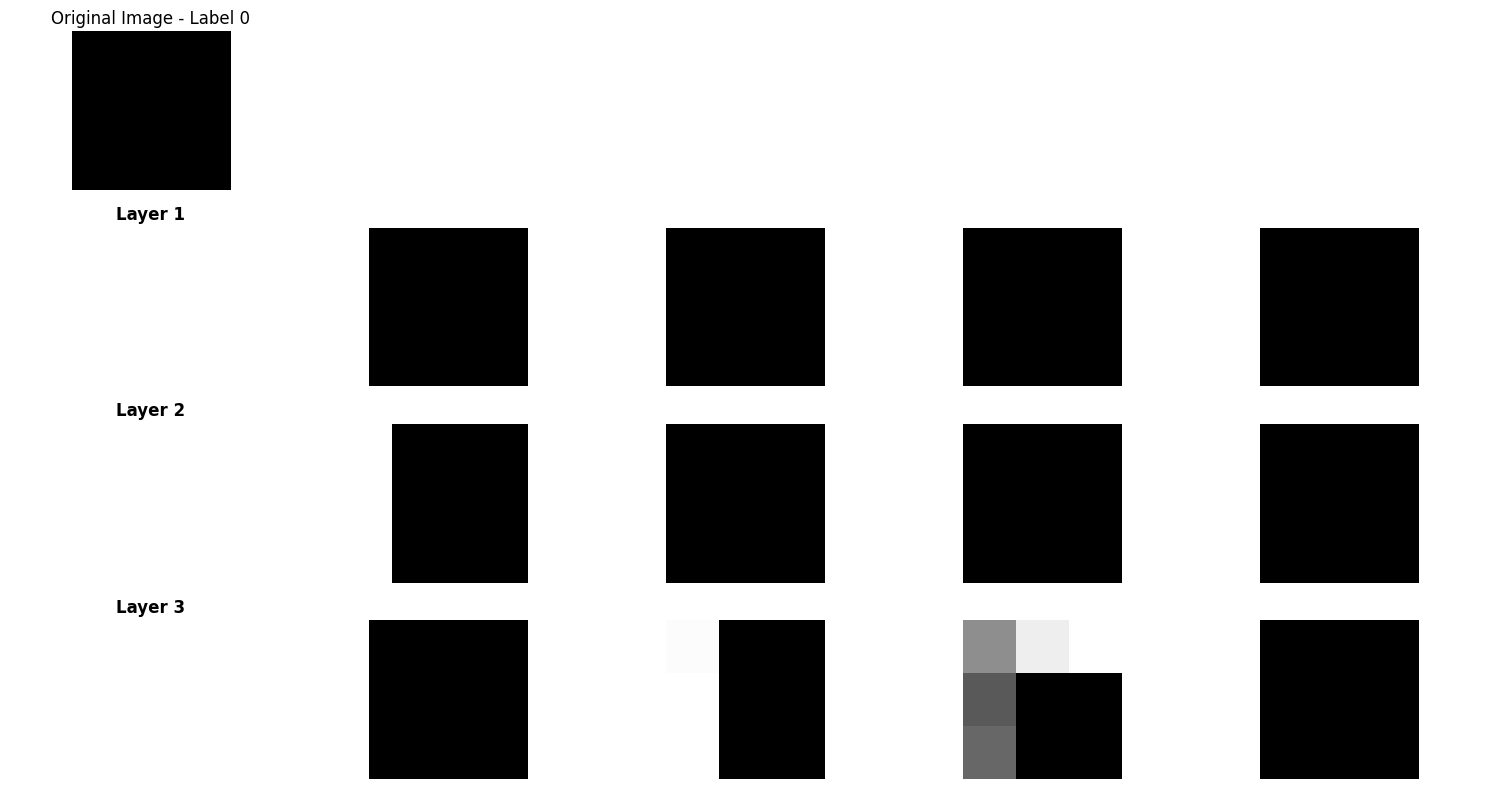

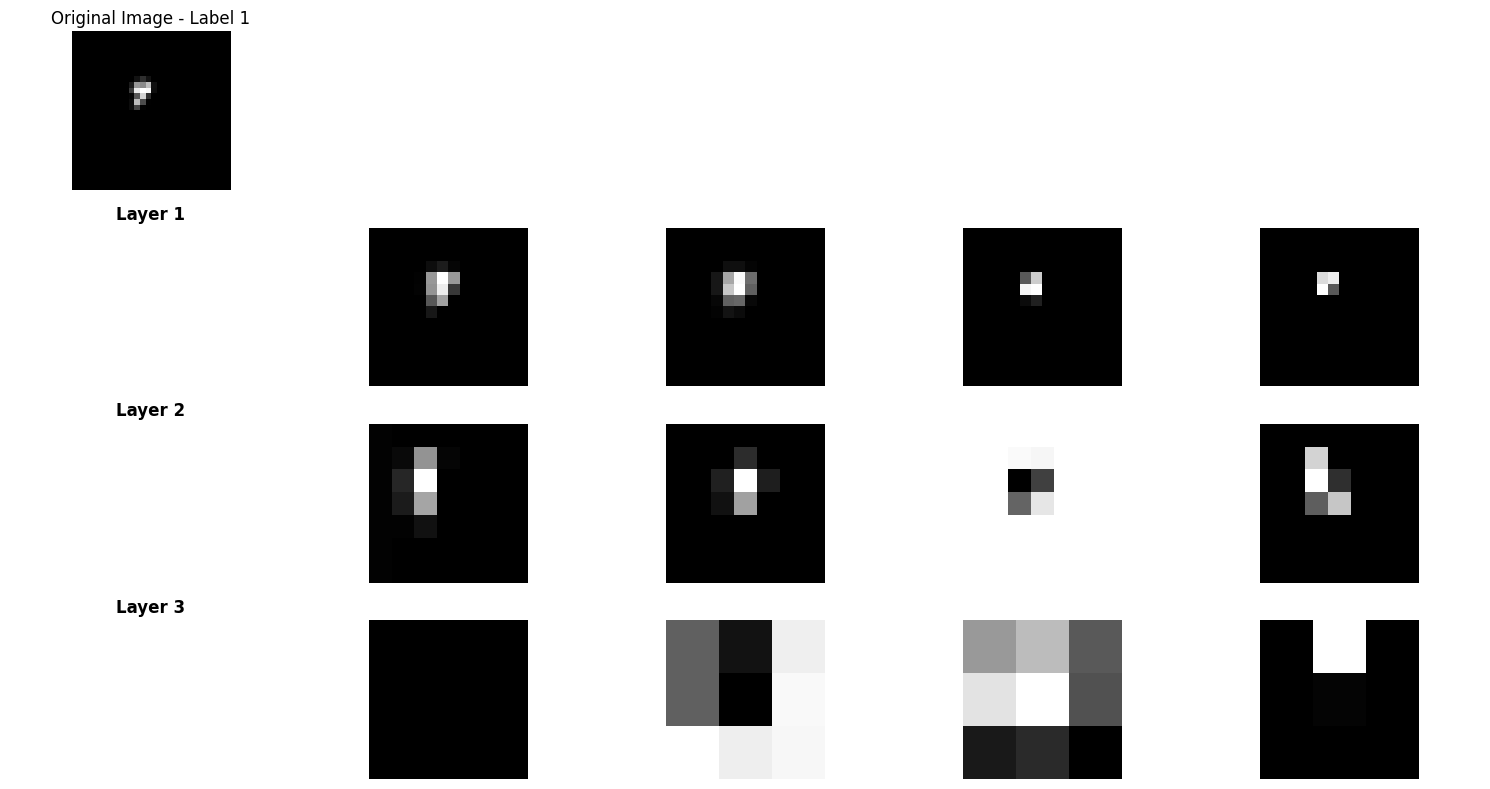

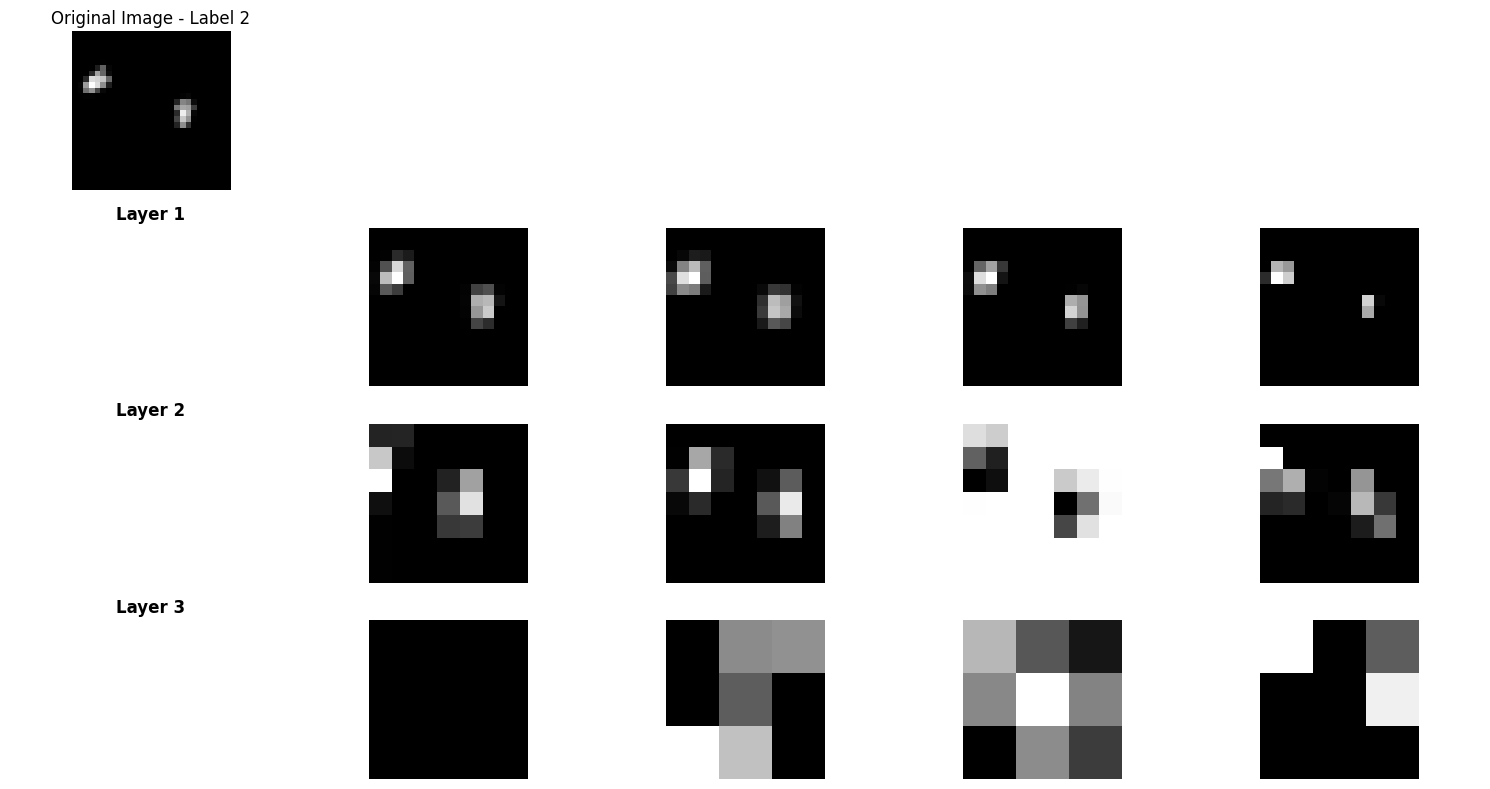

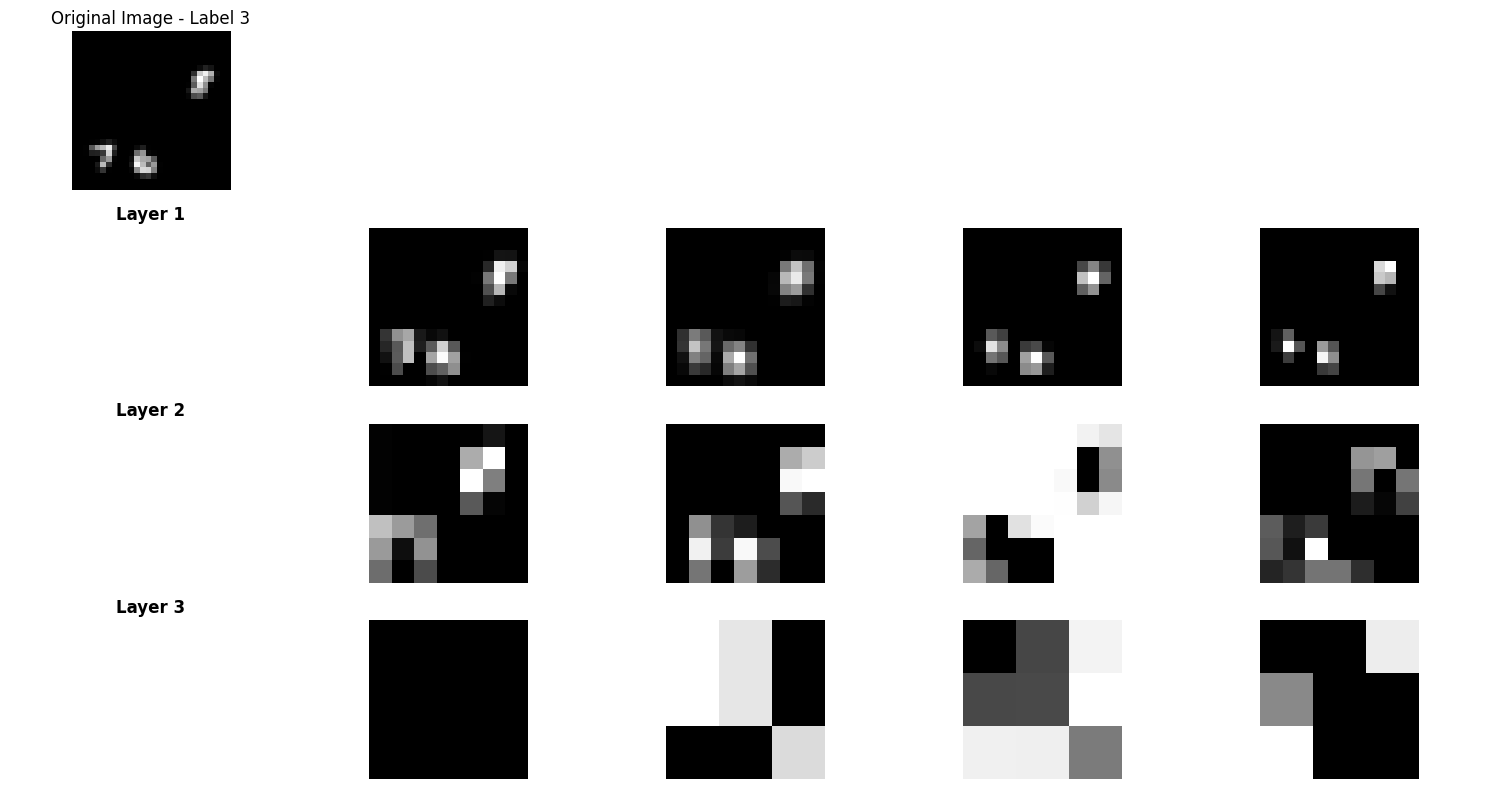

In [43]:
import matplotlib.pyplot as plt
import torch

def visualize_feature_maps(model, data_loader, num_feature_maps=4):
    model.eval()
    label_images = {0: None, 1: None, 2: None, 3: None}
    for images, labels in data_loader:
        for img, label in zip(images, labels):
            label = label.item() 
            if label in label_images and label_images[label] is None:
                label_images[label] = img
            if all(label_images[l] is not None for l in label_images):
                break
        if all(label_images[l] is not None for l in label_images):
            break

    selected_images = [label_images[label] for label in range(4) if label_images[label] is not None]
    selected_images = torch.stack(selected_images)

    with torch.no_grad():
        feature_maps = model(selected_images.to(next(model.parameters()).device), return_feature_maps=True)[1]

    for i in range(len(selected_images)):
        fig, axes = plt.subplots(len(feature_maps) + 1, num_feature_maps + 1, figsize=(15, (len(feature_maps) + 1) * 2))
        axes[0, 0].imshow(selected_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, 0].set_title(f'Original Image - Label {i}')
        axes[0, 0].axis('off')
        for col in range(1, num_feature_maps + 1):
            axes[0, col].axis('off')
        for j in range(len(feature_maps)):
            axes[j + 1, 0].set_title(f'Layer {j + 1}', fontsize=12, fontweight='bold')
            axes[j + 1, 0].axis('off')  

            for k in range(min(num_feature_maps, feature_maps[j].shape[1])):  
                axes[j + 1, k + 1].imshow(feature_maps[j][i, k].cpu().numpy(), cmap='gray')
                axes[j + 1, k + 1].axis('off')

        plt.tight_layout()
        plt.show()

visualize_feature_maps(best_classification_model, test_loader)


Layer 1 Analysis:
- Layer 1 appears to be detecting basic edge and brightness features:
- The feature maps highlight small bright spots and basic shapes against dark backgrounds
- This is consistent across all 4 images where bright pixels stand out prominently
- The activations are localized and small, suggesting this layer focuses on very low-level features
- Different feature maps in this layer seem to respond to different orientations and intensities of these basic features

Layer 2 Analysis:
- Layer 2 shows more complex pattern detection:
- The feature maps reveal larger activated regions compared to Layer 1
- There's evidence of feature combination, where multiple Layer 1 features are being integrated
- We can observe:
  - Elongated bright regions suggesting line detection
  - Multiple bright spots being processed together
  - More varied grayscale values indicating more sophisticated feature detection
  - Larger receptive fields compared to Layer 1

Layer 3 Analysis:
- Layer 3 demonstrates the highest level of abstraction:
- Feature maps show much larger activated regions
- Notable characteristics include:
  - Complex geometric patterns emerging from simpler features
  - Significant variation in activation patterns between different feature maps
  - More distinct black and white regions with clear boundaries
  - Some maps appear to capture overall structural patterns rather than local features
  - Evidence of hierarchical feature composition from previous layers

Progressive Feature Hierarchy:
1. Layer 1 → Basic edges and spots
2. Layer 2 → Combined edges and simple patterns
3. Layer 3 → Complex patterns and structural features

This progression aligns with typical CNN behavior where:
- Earlier layers detect simple, localized features
- Middle layers combine these into more complex patterns
- Later layers assemble these into higher-level structural features

The network appears to be building a hierarchical representation where each subsequent layer uses the features detected by previous layers to construct increasingly complex and abstract representations of the input data.

# Multi Label Classification

### Data Loading and Preprocessing

1. The `load_mnist_data` function has been updated to utilize subfolder names as actual labels for loading the training, validation, and test datasets.
2. One-hot encoding of labels has been implemented to allow the model to recognize that each digit can independently appear in an image.

In [46]:
def one_hot_encode_digit(digit):
    """Creates an 11-dimensional one-hot vector for a single digit or blank."""
    one_hot = np.zeros(11)
    if digit == '*':
        one_hot[10] = 1 
    else:
        one_hot[int(digit)] = 1
    return one_hot

def one_hot_encode_label(label):
    """Encodes the label (up to three digits) as a 33-dimensional vector."""
    label_str = str(label).ljust(3, '*')
    one_hot_encoded = np.concatenate([one_hot_encode_digit(digit) for digit in label_str])
    return one_hot_encoded

In [47]:
images, labels = load_mnist_data(use_label_count=False)

train_dataset = MultiMNISTDataset(images['train'], labels['train'], transform=transform)
val_dataset = MultiMNISTDataset(images['val'], labels['val'], transform=transform)
test_dataset = MultiMNISTDataset(images['test'], labels['test'], transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 3.2.3

Yes, this multi-label CNN requires softmax activation after the final linear layer. The model's 33-dimensional output is divided into three segments of 11 classes each, representing the first, second, and third positions in the sequence. Each segment uses one-hot encoding (0-9 for digits, 11th class for blank), effectively turning order prediction into three parallel classification tasks.

Unlike the simple digit counting classifier, we need softmax activation here to ensure each position contains exactly one prediction. The implementation applies softmax separately to each 11-class segment, ensuring outputs within each segment sum to 1 and provide proper probability distributions over possible digits or blank. This design enforces the constraint that each position must contain exactly one prediction, making it more appropriate than alternatives like sigmoid activation which would allow multiple predictions per position. The loss is calculated by applying CrossEntropyLoss to each segment independently and summing the results: `loss = sum(criterion(outputs[:, i:i+11], labels[:, i:i+11]) for i in range(0, 33, 11))`.

In [48]:
model = MultiLabelCNN(num_conv_layers=3,dropout_rate=0.25).to(device)

model.fit(train_loader, val_loader, epochs=15, lr=0.001)

Training Epoch 1/15: 100%|██████████| 394/394 [00:11<00:00, 35.52it/s]


Epoch [1/15], Training Loss: 4.9750, Training Accuracy: 6.71%
Epoch [1/15], Validation Loss: 4.9252, Validation Accuracy: 5.20%


Training Epoch 2/15: 100%|██████████| 394/394 [00:10<00:00, 36.21it/s]


Epoch [2/15], Training Loss: 4.1536, Training Accuracy: 11.29%
Epoch [2/15], Validation Loss: 4.8540, Validation Accuracy: 4.23%


Training Epoch 3/15: 100%|██████████| 394/394 [00:12<00:00, 30.82it/s]


Epoch [3/15], Training Loss: 3.7212, Training Accuracy: 15.06%
Epoch [3/15], Validation Loss: 4.5671, Validation Accuracy: 5.80%


Training Epoch 4/15: 100%|██████████| 394/394 [00:15<00:00, 26.13it/s]


Epoch [4/15], Training Loss: 3.4293, Training Accuracy: 17.97%
Epoch [4/15], Validation Loss: 4.4288, Validation Accuracy: 5.90%


Training Epoch 5/15: 100%|██████████| 394/394 [00:10<00:00, 35.84it/s]


Epoch [5/15], Training Loss: 3.2229, Training Accuracy: 19.56%
Epoch [5/15], Validation Loss: 4.5171, Validation Accuracy: 6.23%


Training Epoch 6/15: 100%|██████████| 394/394 [00:12<00:00, 31.81it/s]


Epoch [6/15], Training Loss: 3.0527, Training Accuracy: 21.72%
Epoch [6/15], Validation Loss: 4.2957, Validation Accuracy: 7.63%


Training Epoch 7/15: 100%|██████████| 394/394 [00:09<00:00, 41.05it/s]


Epoch [7/15], Training Loss: 2.8813, Training Accuracy: 24.24%
Epoch [7/15], Validation Loss: 4.1665, Validation Accuracy: 8.60%


Training Epoch 8/15: 100%|██████████| 394/394 [00:11<00:00, 34.03it/s]


Epoch [8/15], Training Loss: 2.6734, Training Accuracy: 28.67%
Epoch [8/15], Validation Loss: 3.6543, Validation Accuracy: 13.23%


Training Epoch 9/15: 100%|██████████| 394/394 [00:15<00:00, 26.02it/s]


Epoch [9/15], Training Loss: 2.4069, Training Accuracy: 34.51%
Epoch [9/15], Validation Loss: 3.6060, Validation Accuracy: 15.03%


Training Epoch 10/15: 100%|██████████| 394/394 [00:15<00:00, 26.09it/s]


Epoch [10/15], Training Loss: 2.1800, Training Accuracy: 39.60%
Epoch [10/15], Validation Loss: 3.6928, Validation Accuracy: 16.17%


Training Epoch 11/15: 100%|██████████| 394/394 [00:12<00:00, 31.04it/s]


Epoch [11/15], Training Loss: 2.0163, Training Accuracy: 42.98%
Epoch [11/15], Validation Loss: 3.5871, Validation Accuracy: 16.37%


Training Epoch 12/15: 100%|██████████| 394/394 [00:13<00:00, 29.04it/s]


Epoch [12/15], Training Loss: 1.8954, Training Accuracy: 46.02%
Epoch [12/15], Validation Loss: 3.5093, Validation Accuracy: 18.20%


Training Epoch 13/15: 100%|██████████| 394/394 [00:13<00:00, 29.85it/s]


Epoch [13/15], Training Loss: 1.7609, Training Accuracy: 48.54%
Epoch [13/15], Validation Loss: 3.5801, Validation Accuracy: 20.53%


Training Epoch 14/15: 100%|██████████| 394/394 [00:13<00:00, 29.15it/s]


Epoch [14/15], Training Loss: 1.6319, Training Accuracy: 52.54%
Epoch [14/15], Validation Loss: 3.4593, Validation Accuracy: 21.90%


Training Epoch 15/15: 100%|██████████| 394/394 [00:12<00:00, 32.27it/s]


Epoch [15/15], Training Loss: 1.5279, Training Accuracy: 54.92%
Epoch [15/15], Validation Loss: 3.2981, Validation Accuracy: 25.67%


In [49]:
def evaluate_model(model, test_loader):
    model.eval()
    exact_match_correct = 0
    total = 0
    total_hamming_accuracy = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(model.device), labels.to(model.device).float()
            outputs = model(inputs)
            
            preds = model._set_segment_max_to_one(outputs)
            exact_match_correct += model.exact_match_accuracy(preds, labels)
            
            hamming_accuracy = (preds == labels).float().mean()
            total_hamming_accuracy += hamming_accuracy.item()
            total += labels.size(0)

    exact_match_acc = (exact_match_correct / total) * 100
    avg_hamming_accuracy = (total_hamming_accuracy / len(test_loader)) * 100

    print(f"Exact Match Accuracy: {exact_match_acc:.2f}%")
    print(f"Hamming Accuracy: {avg_hamming_accuracy:.2f}%")

evaluate_model(model, test_loader)


Exact Match Accuracy: 17.28%
Hamming Accuracy: 94.14%


### Hyperparameter Tuning

In [21]:
import torch.nn as nn

hyperparam_combinations = [
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 15},
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 30},
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 45},
    {'lr': 0.001, 'dropout_rate': 0.4, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 30},
    {'lr': 0.001, 'dropout_rate': 0.2, 'num_conv_layers': 2, 'optimizer_choice': 'adam', 'activation_function': 'tanh', 'epochs': 30},
    {'lr': 0.0012, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'adam', 'activation_function': 'relu', 'epochs': 30},
    {'lr': 0.0007, 'dropout_rate': 0.2, 'num_conv_layers': 2, 'optimizer_choice': 'sgd', 'activation_function': 'tanh', 'epochs': 30},
    {'lr': 0.0007, 'dropout_rate': 0.2, 'num_conv_layers': 3, 'optimizer_choice': 'sgd', 'activation_function': 'relu', 'epochs': 30}
]


plot_save_dir = "./figures/multilabel_cnn_loss_plots"
os.makedirs(plot_save_dir, exist_ok=True)

best_multi_classification_model, best_multi_classification_loss, best_multi_classification_combination = None, float('inf'), None
print('Starting Hyperparameter Tuning:')
for idx, params in enumerate(hyperparam_combinations, 1):
    loss_figure_save_path = os.path.join(
        plot_save_dir,
        f"multilabel_loss_combination_{idx}_lr_{params['lr']}_dropout_{params['dropout_rate']}_layers_{params['num_conv_layers']}_activ_{params['activation_function']}_opt_{params['optimizer_choice']}_epochs_{params['epochs']}.png"
    )
    print(f"\nMultilabel CNN for {params['epochs']} epochs with learning rate = {params['lr']}, Dropout = {params['dropout_rate']}, {params['num_conv_layers']} convolutional layers, {params['activation_function']} activation and {params['optimizer_choice']} optimizer")
    model = MultiLabelCNN(
        num_conv_layers=params['num_conv_layers'],
        dropout_rate=params['dropout_rate'],
        optimizer_choice=params['optimizer_choice'],
        activation_function=params['activation_function'],
        device=device,
        loss_figure_save_path = loss_figure_save_path
    )

    model.fit(train_loader, val_loader, epochs=params['epochs'], lr=params['lr'])
    val_loss, val_accuracy = model.evaluate(val_loader, criterion=nn.CrossEntropyLoss())
    
    if val_loss < best_multi_classification_loss:
        best_multi_classification_model = model
        best_multi_classification_loss = val_loss
        best_multi_classification_combination = params
    print("Evaluation on Validation Set")
    evaluate_model(model, val_loader)
    print("Evaluation on Test Set")
    evaluate_model(model, test_loader)

best_params = {
    "best_classification_combination": best_multi_classification_combination
}

params_file_path = os.path.join(plot_save_dir, "best_multilabel_model_params.json")
with open(params_file_path, 'w') as json_file:
    json.dump(best_params, json_file, indent=4)

print("Best Classification Model Combination:", best_classification_combination)
print("Best Regression Model Combination:", best_regression_combination)
print(f"Best parameters saved to {params_file_path}")

Starting Hyperparameter Tuning:

Multilabel CNN for 15 epochs with learning rate = 0.001, Dropout = 0.2, 3 convolutional layers, relu activation and adam optimizer


Training Epoch 1/15: 100%|██████████| 394/394 [00:13<00:00, 30.02it/s]


Epoch [1/15], Training Loss: 4.8715, Training Accuracy: 7.31%
Epoch [1/15], Validation Loss: 4.9581, Validation Accuracy: 5.30%


Training Epoch 2/15: 100%|██████████| 394/394 [00:14<00:00, 26.73it/s]


Epoch [2/15], Training Loss: 4.0157, Training Accuracy: 12.29%
Epoch [2/15], Validation Loss: 4.6602, Validation Accuracy: 4.40%


Training Epoch 3/15: 100%|██████████| 394/394 [00:16<00:00, 23.80it/s]


Epoch [3/15], Training Loss: 3.5196, Training Accuracy: 16.42%
Epoch [3/15], Validation Loss: 4.7965, Validation Accuracy: 3.93%


Training Epoch 4/15: 100%|██████████| 394/394 [00:15<00:00, 25.77it/s]


Epoch [4/15], Training Loss: 3.2404, Training Accuracy: 19.11%
Epoch [4/15], Validation Loss: 4.6163, Validation Accuracy: 4.77%


Training Epoch 5/15: 100%|██████████| 394/394 [00:16<00:00, 24.14it/s]


Epoch [5/15], Training Loss: 3.0088, Training Accuracy: 23.12%
Epoch [5/15], Validation Loss: 4.1579, Validation Accuracy: 7.77%


Training Epoch 6/15: 100%|██████████| 394/394 [00:15<00:00, 25.69it/s]


Epoch [6/15], Training Loss: 2.6986, Training Accuracy: 29.63%
Epoch [6/15], Validation Loss: 3.8544, Validation Accuracy: 11.07%


Training Epoch 7/15: 100%|██████████| 394/394 [00:16<00:00, 23.97it/s]


Epoch [7/15], Training Loss: 2.3369, Training Accuracy: 36.71%
Epoch [7/15], Validation Loss: 3.7199, Validation Accuracy: 16.27%


Training Epoch 8/15: 100%|██████████| 394/394 [00:16<00:00, 23.84it/s]


Epoch [8/15], Training Loss: 2.0621, Training Accuracy: 43.14%
Epoch [8/15], Validation Loss: 3.4571, Validation Accuracy: 18.83%


Training Epoch 9/15: 100%|██████████| 394/394 [00:16<00:00, 23.70it/s]


Epoch [9/15], Training Loss: 1.8244, Training Accuracy: 48.87%
Epoch [9/15], Validation Loss: 3.5780, Validation Accuracy: 23.27%


Training Epoch 10/15: 100%|██████████| 394/394 [00:16<00:00, 23.38it/s]


Epoch [10/15], Training Loss: 1.6398, Training Accuracy: 52.97%
Epoch [10/15], Validation Loss: 2.9612, Validation Accuracy: 26.83%


Training Epoch 11/15: 100%|██████████| 394/394 [00:16<00:00, 23.40it/s]


Epoch [11/15], Training Loss: 1.4563, Training Accuracy: 57.52%
Epoch [11/15], Validation Loss: 2.8617, Validation Accuracy: 31.70%


Training Epoch 12/15: 100%|██████████| 394/394 [00:17<00:00, 22.83it/s]


Epoch [12/15], Training Loss: 1.3287, Training Accuracy: 60.85%
Epoch [12/15], Validation Loss: 2.9360, Validation Accuracy: 33.13%


Training Epoch 13/15: 100%|██████████| 394/394 [00:15<00:00, 25.76it/s]


Epoch [13/15], Training Loss: 1.2239, Training Accuracy: 63.44%
Epoch [13/15], Validation Loss: 2.9124, Validation Accuracy: 36.03%


Training Epoch 14/15: 100%|██████████| 394/394 [00:16<00:00, 23.73it/s]


Epoch [14/15], Training Loss: 1.1232, Training Accuracy: 66.41%
Epoch [14/15], Validation Loss: 2.8915, Validation Accuracy: 35.33%


Training Epoch 15/15: 100%|██████████| 394/394 [00:16<00:00, 24.27it/s]


Epoch [15/15], Training Loss: 1.0555, Training Accuracy: 69.10%
Epoch [15/15], Validation Loss: 2.9758, Validation Accuracy: 35.40%
Evaluation on Validation Set
Exact Match Accuracy: 35.40%
Hamming Accuracy: 95.65%
Evaluation on Test Set
Exact Match Accuracy: 28.89%
Hamming Accuracy: 95.25%

Multilabel CNN for 30 epochs with learning rate = 0.001, Dropout = 0.2, 3 convolutional layers, relu activation and adam optimizer


Training Epoch 1/30: 100%|██████████| 394/394 [00:15<00:00, 25.57it/s]


Epoch [1/30], Training Loss: 4.9308, Training Accuracy: 6.46%
Epoch [1/30], Validation Loss: 5.2844, Validation Accuracy: 5.13%


Training Epoch 2/30: 100%|██████████| 394/394 [00:15<00:00, 25.90it/s]


Epoch [2/30], Training Loss: 4.1511, Training Accuracy: 11.24%
Epoch [2/30], Validation Loss: 4.7547, Validation Accuracy: 4.50%


Training Epoch 3/30: 100%|██████████| 394/394 [00:18<00:00, 21.73it/s]


Epoch [3/30], Training Loss: 3.6971, Training Accuracy: 14.96%
Epoch [3/30], Validation Loss: 4.5733, Validation Accuracy: 5.70%


Training Epoch 4/30: 100%|██████████| 394/394 [00:15<00:00, 24.72it/s]


Epoch [4/30], Training Loss: 3.4048, Training Accuracy: 17.10%
Epoch [4/30], Validation Loss: 4.4989, Validation Accuracy: 4.83%


Training Epoch 5/30: 100%|██████████| 394/394 [00:15<00:00, 24.77it/s]


Epoch [5/30], Training Loss: 3.2203, Training Accuracy: 19.75%
Epoch [5/30], Validation Loss: 4.4521, Validation Accuracy: 4.33%


Training Epoch 6/30: 100%|██████████| 394/394 [00:17<00:00, 22.15it/s]


Epoch [6/30], Training Loss: 3.0510, Training Accuracy: 22.30%
Epoch [6/30], Validation Loss: 4.4781, Validation Accuracy: 6.47%


Training Epoch 7/30: 100%|██████████| 394/394 [00:15<00:00, 25.35it/s]


Epoch [7/30], Training Loss: 2.8988, Training Accuracy: 24.98%
Epoch [7/30], Validation Loss: 4.4486, Validation Accuracy: 6.93%


Training Epoch 8/30: 100%|██████████| 394/394 [00:16<00:00, 23.92it/s]


Epoch [8/30], Training Loss: 2.6916, Training Accuracy: 28.92%
Epoch [8/30], Validation Loss: 4.0273, Validation Accuracy: 10.63%


Training Epoch 9/30: 100%|██████████| 394/394 [00:17<00:00, 23.12it/s]


Epoch [9/30], Training Loss: 2.4977, Training Accuracy: 34.36%
Epoch [9/30], Validation Loss: 4.4296, Validation Accuracy: 12.33%


Training Epoch 10/30: 100%|██████████| 394/394 [00:17<00:00, 21.92it/s]


Epoch [10/30], Training Loss: 2.2506, Training Accuracy: 39.06%
Epoch [10/30], Validation Loss: 3.5817, Validation Accuracy: 16.83%


Training Epoch 11/30: 100%|██████████| 394/394 [00:16<00:00, 23.51it/s]


Epoch [11/30], Training Loss: 2.0292, Training Accuracy: 44.38%
Epoch [11/30], Validation Loss: 3.7054, Validation Accuracy: 18.90%


Training Epoch 12/30: 100%|██████████| 394/394 [00:17<00:00, 22.39it/s]


Epoch [12/30], Training Loss: 1.8460, Training Accuracy: 48.61%
Epoch [12/30], Validation Loss: 3.2214, Validation Accuracy: 25.10%


Training Epoch 13/30: 100%|██████████| 394/394 [00:17<00:00, 22.02it/s]


Epoch [13/30], Training Loss: 1.6637, Training Accuracy: 52.45%
Epoch [13/30], Validation Loss: 3.4210, Validation Accuracy: 23.03%


Training Epoch 14/30: 100%|██████████| 394/394 [00:17<00:00, 22.50it/s]


Epoch [14/30], Training Loss: 1.5002, Training Accuracy: 57.26%
Epoch [14/30], Validation Loss: 3.0146, Validation Accuracy: 29.00%


Training Epoch 15/30: 100%|██████████| 394/394 [00:17<00:00, 22.12it/s]


Epoch [15/30], Training Loss: 1.3447, Training Accuracy: 61.17%
Epoch [15/30], Validation Loss: 3.2112, Validation Accuracy: 29.30%


Training Epoch 16/30: 100%|██████████| 394/394 [00:16<00:00, 24.11it/s]


Epoch [16/30], Training Loss: 1.2215, Training Accuracy: 64.45%
Epoch [16/30], Validation Loss: 2.8222, Validation Accuracy: 36.13%


Training Epoch 17/30: 100%|██████████| 394/394 [00:16<00:00, 24.01it/s]


Epoch [17/30], Training Loss: 1.0981, Training Accuracy: 67.73%
Epoch [17/30], Validation Loss: 2.7964, Validation Accuracy: 36.17%


Training Epoch 18/30: 100%|██████████| 394/394 [00:17<00:00, 23.01it/s]


Epoch [18/30], Training Loss: 1.0013, Training Accuracy: 70.48%
Epoch [18/30], Validation Loss: 2.7917, Validation Accuracy: 38.93%


Training Epoch 19/30: 100%|██████████| 394/394 [00:16<00:00, 24.08it/s]


Epoch [19/30], Training Loss: 0.9251, Training Accuracy: 72.68%
Epoch [19/30], Validation Loss: 2.9862, Validation Accuracy: 39.57%


Training Epoch 20/30: 100%|██████████| 394/394 [00:18<00:00, 21.65it/s]


Epoch [20/30], Training Loss: 0.8399, Training Accuracy: 74.29%
Epoch [20/30], Validation Loss: 2.8159, Validation Accuracy: 40.37%


Training Epoch 21/30: 100%|██████████| 394/394 [00:13<00:00, 29.44it/s]


Epoch [21/30], Training Loss: 0.7705, Training Accuracy: 76.17%
Epoch [21/30], Validation Loss: 2.8457, Validation Accuracy: 41.80%


Training Epoch 22/30: 100%|██████████| 394/394 [00:13<00:00, 28.33it/s]


Epoch [22/30], Training Loss: 0.7280, Training Accuracy: 77.70%
Epoch [22/30], Validation Loss: 2.8155, Validation Accuracy: 41.03%


Training Epoch 23/30: 100%|██████████| 394/394 [00:13<00:00, 28.68it/s]


Epoch [23/30], Training Loss: 0.6706, Training Accuracy: 78.81%
Epoch [23/30], Validation Loss: 3.1681, Validation Accuracy: 38.90%


Training Epoch 24/30: 100%|██████████| 394/394 [00:13<00:00, 29.44it/s]


Epoch [24/30], Training Loss: 0.6148, Training Accuracy: 80.76%
Epoch [24/30], Validation Loss: 3.2948, Validation Accuracy: 38.67%


Training Epoch 25/30: 100%|██████████| 394/394 [00:13<00:00, 30.13it/s]


Epoch [25/30], Training Loss: 0.5720, Training Accuracy: 81.34%
Epoch [25/30], Validation Loss: 2.9173, Validation Accuracy: 44.03%


Training Epoch 26/30: 100%|██████████| 394/394 [00:13<00:00, 29.56it/s]


Epoch [26/30], Training Loss: 0.5308, Training Accuracy: 83.24%
Epoch [26/30], Validation Loss: 3.0958, Validation Accuracy: 42.70%


Training Epoch 27/30: 100%|██████████| 394/394 [00:13<00:00, 29.24it/s]


Epoch [27/30], Training Loss: 0.4930, Training Accuracy: 84.04%
Epoch [27/30], Validation Loss: 3.1636, Validation Accuracy: 43.53%


Training Epoch 28/30: 100%|██████████| 394/394 [00:13<00:00, 28.73it/s]


Epoch [28/30], Training Loss: 0.4539, Training Accuracy: 85.01%
Epoch [28/30], Validation Loss: 3.4537, Validation Accuracy: 41.97%


Training Epoch 29/30: 100%|██████████| 394/394 [00:13<00:00, 29.87it/s]


Epoch [29/30], Training Loss: 0.4287, Training Accuracy: 85.49%
Epoch [29/30], Validation Loss: 3.3945, Validation Accuracy: 45.03%


Training Epoch 30/30: 100%|██████████| 394/394 [00:13<00:00, 30.00it/s]


Epoch [30/30], Training Loss: 0.4028, Training Accuracy: 86.68%
Epoch [30/30], Validation Loss: 3.3088, Validation Accuracy: 45.43%
Evaluation on Validation Set
Exact Match Accuracy: 45.43%
Hamming Accuracy: 96.26%
Evaluation on Test Set
Exact Match Accuracy: 37.13%
Hamming Accuracy: 95.94%

Multilabel CNN for 45 epochs with learning rate = 0.001, Dropout = 0.2, 3 convolutional layers, relu activation and adam optimizer


Training Epoch 1/45: 100%|██████████| 394/394 [00:12<00:00, 32.65it/s]


Epoch [1/45], Training Loss: 4.8985, Training Accuracy: 7.21%
Epoch [1/45], Validation Loss: 5.0569, Validation Accuracy: 5.73%


Training Epoch 2/45: 100%|██████████| 394/394 [00:11<00:00, 34.20it/s]


Epoch [2/45], Training Loss: 4.0724, Training Accuracy: 11.94%
Epoch [2/45], Validation Loss: 4.9115, Validation Accuracy: 4.20%


Training Epoch 3/45: 100%|██████████| 394/394 [00:13<00:00, 28.28it/s]


Epoch [3/45], Training Loss: 3.6110, Training Accuracy: 16.27%
Epoch [3/45], Validation Loss: 5.0442, Validation Accuracy: 5.57%


Training Epoch 4/45: 100%|██████████| 394/394 [00:16<00:00, 24.57it/s]


Epoch [4/45], Training Loss: 3.3639, Training Accuracy: 18.66%
Epoch [4/45], Validation Loss: 5.1463, Validation Accuracy: 4.17%


Training Epoch 5/45: 100%|██████████| 394/394 [00:13<00:00, 29.68it/s]


Epoch [5/45], Training Loss: 3.1581, Training Accuracy: 20.90%
Epoch [5/45], Validation Loss: 5.2007, Validation Accuracy: 6.00%


Training Epoch 6/45: 100%|██████████| 394/394 [00:13<00:00, 29.38it/s]


Epoch [6/45], Training Loss: 2.9738, Training Accuracy: 24.22%
Epoch [6/45], Validation Loss: 4.3416, Validation Accuracy: 6.30%


Training Epoch 7/45: 100%|██████████| 394/394 [00:13<00:00, 29.26it/s]


Epoch [7/45], Training Loss: 2.7443, Training Accuracy: 29.48%
Epoch [7/45], Validation Loss: 4.0671, Validation Accuracy: 7.97%


Training Epoch 8/45: 100%|██████████| 394/394 [00:13<00:00, 28.52it/s]


Epoch [8/45], Training Loss: 2.5084, Training Accuracy: 33.97%
Epoch [8/45], Validation Loss: 4.2245, Validation Accuracy: 9.83%


Training Epoch 9/45: 100%|██████████| 394/394 [00:14<00:00, 27.39it/s]


Epoch [9/45], Training Loss: 2.3211, Training Accuracy: 37.19%
Epoch [9/45], Validation Loss: 3.6561, Validation Accuracy: 11.80%


Training Epoch 10/45: 100%|██████████| 394/394 [00:14<00:00, 27.68it/s]


Epoch [10/45], Training Loss: 2.1297, Training Accuracy: 40.99%
Epoch [10/45], Validation Loss: 3.6994, Validation Accuracy: 14.97%


Training Epoch 11/45: 100%|██████████| 394/394 [00:13<00:00, 28.98it/s]


Epoch [11/45], Training Loss: 1.9727, Training Accuracy: 44.52%
Epoch [11/45], Validation Loss: 3.5209, Validation Accuracy: 18.27%


Training Epoch 12/45: 100%|██████████| 394/394 [00:13<00:00, 29.57it/s]


Epoch [12/45], Training Loss: 1.8256, Training Accuracy: 48.06%
Epoch [12/45], Validation Loss: 3.5001, Validation Accuracy: 19.60%


Training Epoch 13/45: 100%|██████████| 394/394 [00:14<00:00, 28.08it/s]


Epoch [13/45], Training Loss: 1.6712, Training Accuracy: 52.40%
Epoch [13/45], Validation Loss: 3.0927, Validation Accuracy: 23.77%


Training Epoch 14/45: 100%|██████████| 394/394 [00:14<00:00, 27.79it/s]


Epoch [14/45], Training Loss: 1.5198, Training Accuracy: 56.10%
Epoch [14/45], Validation Loss: 3.2933, Validation Accuracy: 24.87%


Training Epoch 15/45: 100%|██████████| 394/394 [00:13<00:00, 29.71it/s]


Epoch [15/45], Training Loss: 1.4070, Training Accuracy: 59.29%
Epoch [15/45], Validation Loss: 3.0764, Validation Accuracy: 28.27%


Training Epoch 16/45: 100%|██████████| 394/394 [00:12<00:00, 30.58it/s]


Epoch [16/45], Training Loss: 1.2945, Training Accuracy: 62.18%
Epoch [16/45], Validation Loss: 3.3551, Validation Accuracy: 28.43%


Training Epoch 17/45: 100%|██████████| 394/394 [00:14<00:00, 28.10it/s]


Epoch [17/45], Training Loss: 1.1923, Training Accuracy: 64.37%
Epoch [17/45], Validation Loss: 3.0231, Validation Accuracy: 33.83%


Training Epoch 18/45: 100%|██████████| 394/394 [00:13<00:00, 29.36it/s]


Epoch [18/45], Training Loss: 1.0972, Training Accuracy: 67.19%
Epoch [18/45], Validation Loss: 3.0660, Validation Accuracy: 34.47%


Training Epoch 19/45: 100%|██████████| 394/394 [00:15<00:00, 25.54it/s]


Epoch [19/45], Training Loss: 1.0019, Training Accuracy: 69.49%
Epoch [19/45], Validation Loss: 3.1530, Validation Accuracy: 35.73%


Training Epoch 20/45: 100%|██████████| 394/394 [00:17<00:00, 22.15it/s]


Epoch [20/45], Training Loss: 0.9274, Training Accuracy: 71.93%
Epoch [20/45], Validation Loss: 3.0942, Validation Accuracy: 37.60%


Training Epoch 21/45: 100%|██████████| 394/394 [00:16<00:00, 23.40it/s]


Epoch [21/45], Training Loss: 0.8612, Training Accuracy: 73.83%
Epoch [21/45], Validation Loss: 3.3791, Validation Accuracy: 37.90%


Training Epoch 22/45: 100%|██████████| 394/394 [00:16<00:00, 24.25it/s]


Epoch [22/45], Training Loss: 0.7910, Training Accuracy: 75.48%
Epoch [22/45], Validation Loss: 3.1707, Validation Accuracy: 38.97%


Training Epoch 23/45: 100%|██████████| 394/394 [00:17<00:00, 22.42it/s]


Epoch [23/45], Training Loss: 0.7270, Training Accuracy: 77.22%
Epoch [23/45], Validation Loss: 3.1219, Validation Accuracy: 38.73%


Training Epoch 24/45: 100%|██████████| 394/394 [00:18<00:00, 21.76it/s]


Epoch [24/45], Training Loss: 0.6868, Training Accuracy: 78.24%
Epoch [24/45], Validation Loss: 3.1842, Validation Accuracy: 40.07%


Training Epoch 25/45: 100%|██████████| 394/394 [00:18<00:00, 21.79it/s]


Epoch [25/45], Training Loss: 0.6284, Training Accuracy: 80.46%
Epoch [25/45], Validation Loss: 3.0709, Validation Accuracy: 42.50%


Training Epoch 26/45: 100%|██████████| 394/394 [00:18<00:00, 21.54it/s]


Epoch [26/45], Training Loss: 0.6021, Training Accuracy: 81.03%
Epoch [26/45], Validation Loss: 3.0067, Validation Accuracy: 41.23%


Training Epoch 27/45: 100%|██████████| 394/394 [00:17<00:00, 22.01it/s]


Epoch [27/45], Training Loss: 0.5585, Training Accuracy: 81.99%
Epoch [27/45], Validation Loss: 3.1734, Validation Accuracy: 41.80%


Training Epoch 28/45: 100%|██████████| 394/394 [00:18<00:00, 20.95it/s]


Epoch [28/45], Training Loss: 0.5121, Training Accuracy: 82.94%
Epoch [28/45], Validation Loss: 3.1917, Validation Accuracy: 42.03%


Training Epoch 29/45: 100%|██████████| 394/394 [00:17<00:00, 22.23it/s]


Epoch [29/45], Training Loss: 0.4749, Training Accuracy: 84.66%
Epoch [29/45], Validation Loss: 3.7961, Validation Accuracy: 41.60%


Training Epoch 30/45: 100%|██████████| 394/394 [00:18<00:00, 21.07it/s]


Epoch [30/45], Training Loss: 0.4529, Training Accuracy: 85.06%
Epoch [30/45], Validation Loss: 3.4726, Validation Accuracy: 44.43%


Training Epoch 31/45: 100%|██████████| 394/394 [00:19<00:00, 20.43it/s]


Epoch [31/45], Training Loss: 0.4304, Training Accuracy: 85.87%
Epoch [31/45], Validation Loss: 3.6565, Validation Accuracy: 43.20%


Training Epoch 32/45: 100%|██████████| 394/394 [00:17<00:00, 22.45it/s]


Epoch [32/45], Training Loss: 0.3900, Training Accuracy: 87.28%
Epoch [32/45], Validation Loss: 3.2712, Validation Accuracy: 44.77%


Training Epoch 33/45: 100%|██████████| 394/394 [00:17<00:00, 22.63it/s]


Epoch [33/45], Training Loss: 0.3815, Training Accuracy: 87.51%
Epoch [33/45], Validation Loss: 3.8526, Validation Accuracy: 44.17%


Training Epoch 34/45: 100%|██████████| 394/394 [00:19<00:00, 20.64it/s]


Epoch [34/45], Training Loss: 0.3520, Training Accuracy: 88.37%
Epoch [34/45], Validation Loss: 3.4152, Validation Accuracy: 44.93%


Training Epoch 35/45: 100%|██████████| 394/394 [00:19<00:00, 20.51it/s]


Epoch [35/45], Training Loss: 0.3246, Training Accuracy: 89.13%
Epoch [35/45], Validation Loss: 3.7834, Validation Accuracy: 47.30%


Training Epoch 36/45: 100%|██████████| 394/394 [00:18<00:00, 21.28it/s]


Epoch [36/45], Training Loss: 0.3158, Training Accuracy: 89.42%
Epoch [36/45], Validation Loss: 3.7468, Validation Accuracy: 44.33%


Training Epoch 37/45: 100%|██████████| 394/394 [00:17<00:00, 22.81it/s]


Epoch [37/45], Training Loss: 0.3021, Training Accuracy: 89.64%
Epoch [37/45], Validation Loss: 4.1676, Validation Accuracy: 43.83%


Training Epoch 38/45: 100%|██████████| 394/394 [00:18<00:00, 21.38it/s]


Epoch [38/45], Training Loss: 0.2843, Training Accuracy: 90.73%
Epoch [38/45], Validation Loss: 3.8185, Validation Accuracy: 46.20%


Training Epoch 39/45: 100%|██████████| 394/394 [00:17<00:00, 21.96it/s]


Epoch [39/45], Training Loss: 0.2651, Training Accuracy: 90.98%
Epoch [39/45], Validation Loss: 3.9187, Validation Accuracy: 46.27%


Training Epoch 40/45: 100%|██████████| 394/394 [00:17<00:00, 22.36it/s]


Epoch [40/45], Training Loss: 0.2698, Training Accuracy: 90.90%
Epoch [40/45], Validation Loss: 3.7907, Validation Accuracy: 45.47%


Training Epoch 41/45: 100%|██████████| 394/394 [00:17<00:00, 22.63it/s]


Epoch [41/45], Training Loss: 0.2454, Training Accuracy: 91.70%
Epoch [41/45], Validation Loss: 4.0968, Validation Accuracy: 47.33%


Training Epoch 42/45: 100%|██████████| 394/394 [00:17<00:00, 22.51it/s]


Epoch [42/45], Training Loss: 0.2363, Training Accuracy: 91.90%
Epoch [42/45], Validation Loss: 3.8759, Validation Accuracy: 46.23%


Training Epoch 43/45: 100%|██████████| 394/394 [00:19<00:00, 19.91it/s]


Epoch [43/45], Training Loss: 0.2145, Training Accuracy: 92.58%
Epoch [43/45], Validation Loss: 4.2223, Validation Accuracy: 45.40%


Training Epoch 44/45: 100%|██████████| 394/394 [00:17<00:00, 21.90it/s]


Epoch [44/45], Training Loss: 0.2401, Training Accuracy: 91.98%
Epoch [44/45], Validation Loss: 3.5583, Validation Accuracy: 48.43%


Training Epoch 45/45: 100%|██████████| 394/394 [00:19<00:00, 20.72it/s]


Epoch [45/45], Training Loss: 0.2175, Training Accuracy: 92.63%
Epoch [45/45], Validation Loss: 3.9295, Validation Accuracy: 45.83%
Evaluation on Validation Set
Exact Match Accuracy: 45.83%
Hamming Accuracy: 96.45%
Evaluation on Test Set
Exact Match Accuracy: 33.48%
Hamming Accuracy: 95.70%

Multilabel CNN for 30 epochs with learning rate = 0.001, Dropout = 0.4, 3 convolutional layers, relu activation and adam optimizer


Training Epoch 1/30: 100%|██████████| 394/394 [00:15<00:00, 25.70it/s]


Epoch [1/30], Training Loss: 5.1043, Training Accuracy: 6.06%
Epoch [1/30], Validation Loss: 5.1870, Validation Accuracy: 3.63%


Training Epoch 2/30: 100%|██████████| 394/394 [00:16<00:00, 23.85it/s]


Epoch [2/30], Training Loss: 4.3426, Training Accuracy: 9.77%
Epoch [2/30], Validation Loss: 5.1040, Validation Accuracy: 3.90%


Training Epoch 3/30: 100%|██████████| 394/394 [00:17<00:00, 22.22it/s]


Epoch [3/30], Training Loss: 3.9750, Training Accuracy: 12.22%
Epoch [3/30], Validation Loss: 4.8127, Validation Accuracy: 5.13%


Training Epoch 4/30: 100%|██████████| 394/394 [00:18<00:00, 21.87it/s]


Epoch [4/30], Training Loss: 3.6727, Training Accuracy: 15.01%
Epoch [4/30], Validation Loss: 4.5890, Validation Accuracy: 4.57%


Training Epoch 5/30: 100%|██████████| 394/394 [00:18<00:00, 21.28it/s]


Epoch [5/30], Training Loss: 3.4296, Training Accuracy: 17.42%
Epoch [5/30], Validation Loss: 4.7914, Validation Accuracy: 4.50%


Training Epoch 6/30: 100%|██████████| 394/394 [00:17<00:00, 22.26it/s]


Epoch [6/30], Training Loss: 3.2483, Training Accuracy: 20.16%
Epoch [6/30], Validation Loss: 4.2746, Validation Accuracy: 6.57%


Training Epoch 7/30: 100%|██████████| 394/394 [00:17<00:00, 22.39it/s]


Epoch [7/30], Training Loss: 3.0897, Training Accuracy: 21.79%
Epoch [7/30], Validation Loss: 4.4112, Validation Accuracy: 6.13%


Training Epoch 8/30: 100%|██████████| 394/394 [00:17<00:00, 22.06it/s]


Epoch [8/30], Training Loss: 2.9681, Training Accuracy: 23.74%
Epoch [8/30], Validation Loss: 4.2127, Validation Accuracy: 7.00%


Training Epoch 9/30: 100%|██████████| 394/394 [00:18<00:00, 21.88it/s]


Epoch [9/30], Training Loss: 2.8587, Training Accuracy: 25.59%
Epoch [9/30], Validation Loss: 4.1955, Validation Accuracy: 8.27%


Training Epoch 10/30: 100%|██████████| 394/394 [00:18<00:00, 21.67it/s]


Epoch [10/30], Training Loss: 2.7747, Training Accuracy: 27.02%
Epoch [10/30], Validation Loss: 4.2378, Validation Accuracy: 9.23%


Training Epoch 11/30: 100%|██████████| 394/394 [00:18<00:00, 21.60it/s]


Epoch [11/30], Training Loss: 2.6418, Training Accuracy: 30.02%
Epoch [11/30], Validation Loss: 4.1950, Validation Accuracy: 10.27%


Training Epoch 12/30: 100%|██████████| 394/394 [00:16<00:00, 23.62it/s]


Epoch [12/30], Training Loss: 2.5219, Training Accuracy: 32.61%
Epoch [12/30], Validation Loss: 3.9935, Validation Accuracy: 10.30%


Training Epoch 13/30: 100%|██████████| 394/394 [00:18<00:00, 21.87it/s]


Epoch [13/30], Training Loss: 2.3844, Training Accuracy: 35.28%
Epoch [13/30], Validation Loss: 3.7494, Validation Accuracy: 14.60%


Training Epoch 14/30: 100%|██████████| 394/394 [00:18<00:00, 21.87it/s]


Epoch [14/30], Training Loss: 2.2497, Training Accuracy: 38.75%
Epoch [14/30], Validation Loss: 3.9250, Validation Accuracy: 14.67%


Training Epoch 15/30: 100%|██████████| 394/394 [00:18<00:00, 21.21it/s]


Epoch [15/30], Training Loss: 2.1441, Training Accuracy: 40.43%
Epoch [15/30], Validation Loss: 3.8497, Validation Accuracy: 15.97%


Training Epoch 16/30: 100%|██████████| 394/394 [00:17<00:00, 22.70it/s]


Epoch [16/30], Training Loss: 2.0291, Training Accuracy: 43.82%
Epoch [16/30], Validation Loss: 3.6493, Validation Accuracy: 16.90%


Training Epoch 17/30: 100%|██████████| 394/394 [00:17<00:00, 22.31it/s]


Epoch [17/30], Training Loss: 1.9598, Training Accuracy: 44.76%
Epoch [17/30], Validation Loss: 3.6306, Validation Accuracy: 19.63%


Training Epoch 18/30: 100%|██████████| 394/394 [00:17<00:00, 22.28it/s]


Epoch [18/30], Training Loss: 1.8579, Training Accuracy: 47.57%
Epoch [18/30], Validation Loss: 3.5377, Validation Accuracy: 22.67%


Training Epoch 19/30: 100%|██████████| 394/394 [00:21<00:00, 18.15it/s]


Epoch [19/30], Training Loss: 1.7550, Training Accuracy: 49.81%
Epoch [19/30], Validation Loss: 3.2761, Validation Accuracy: 25.10%


Training Epoch 20/30: 100%|██████████| 394/394 [00:16<00:00, 23.42it/s]


Epoch [20/30], Training Loss: 1.6627, Training Accuracy: 52.64%
Epoch [20/30], Validation Loss: 3.4964, Validation Accuracy: 26.77%


Training Epoch 21/30: 100%|██████████| 394/394 [00:15<00:00, 26.20it/s]


Epoch [21/30], Training Loss: 1.5773, Training Accuracy: 55.19%
Epoch [21/30], Validation Loss: 3.4724, Validation Accuracy: 29.00%


Training Epoch 22/30: 100%|██████████| 394/394 [00:15<00:00, 25.93it/s]


Epoch [22/30], Training Loss: 1.4736, Training Accuracy: 57.47%
Epoch [22/30], Validation Loss: 3.5863, Validation Accuracy: 30.23%


Training Epoch 23/30: 100%|██████████| 394/394 [00:14<00:00, 26.42it/s]


Epoch [23/30], Training Loss: 1.3906, Training Accuracy: 59.59%
Epoch [23/30], Validation Loss: 3.4706, Validation Accuracy: 32.50%


Training Epoch 24/30: 100%|██████████| 394/394 [00:13<00:00, 29.85it/s]


Epoch [24/30], Training Loss: 1.3286, Training Accuracy: 61.30%
Epoch [24/30], Validation Loss: 3.1774, Validation Accuracy: 35.63%


Training Epoch 25/30: 100%|██████████| 394/394 [00:14<00:00, 26.93it/s]


Epoch [25/30], Training Loss: 1.2636, Training Accuracy: 62.82%
Epoch [25/30], Validation Loss: 3.3070, Validation Accuracy: 36.43%


Training Epoch 26/30: 100%|██████████| 394/394 [00:14<00:00, 27.24it/s]


Epoch [26/30], Training Loss: 1.1841, Training Accuracy: 65.06%
Epoch [26/30], Validation Loss: 3.3548, Validation Accuracy: 36.03%


Training Epoch 27/30: 100%|██████████| 394/394 [00:14<00:00, 27.19it/s]


Epoch [27/30], Training Loss: 1.1439, Training Accuracy: 65.80%
Epoch [27/30], Validation Loss: 3.2966, Validation Accuracy: 36.00%


Training Epoch 28/30: 100%|██████████| 394/394 [00:14<00:00, 26.75it/s]


Epoch [28/30], Training Loss: 1.0851, Training Accuracy: 67.59%
Epoch [28/30], Validation Loss: 3.2984, Validation Accuracy: 36.00%


Training Epoch 29/30: 100%|██████████| 394/394 [00:17<00:00, 22.96it/s]


Epoch [29/30], Training Loss: 1.0362, Training Accuracy: 68.37%
Epoch [29/30], Validation Loss: 3.0783, Validation Accuracy: 39.57%


Training Epoch 30/30: 100%|██████████| 394/394 [00:22<00:00, 17.80it/s]


Epoch [30/30], Training Loss: 1.0013, Training Accuracy: 69.56%
Epoch [30/30], Validation Loss: 3.1204, Validation Accuracy: 41.03%
Evaluation on Validation Set
Exact Match Accuracy: 41.03%
Hamming Accuracy: 96.04%
Evaluation on Test Set
Exact Match Accuracy: 30.72%
Hamming Accuracy: 95.47%

Multilabel CNN for 30 epochs with learning rate = 0.001, Dropout = 0.2, 2 convolutional layers, tanh activation and adam optimizer


Training Epoch 1/30: 100%|██████████| 394/394 [00:14<00:00, 26.38it/s]


Epoch [1/30], Training Loss: 4.7631, Training Accuracy: 7.39%
Epoch [1/30], Validation Loss: 4.9630, Validation Accuracy: 4.63%


Training Epoch 2/30: 100%|██████████| 394/394 [00:15<00:00, 25.79it/s]


Epoch [2/30], Training Loss: 4.2743, Training Accuracy: 10.42%
Epoch [2/30], Validation Loss: 4.7790, Validation Accuracy: 4.53%


Training Epoch 3/30: 100%|██████████| 394/394 [00:14<00:00, 27.40it/s]


Epoch [3/30], Training Loss: 3.9434, Training Accuracy: 13.07%
Epoch [3/30], Validation Loss: 4.5076, Validation Accuracy: 7.03%


Training Epoch 4/30: 100%|██████████| 394/394 [00:15<00:00, 25.43it/s]


Epoch [4/30], Training Loss: 3.6491, Training Accuracy: 15.68%
Epoch [4/30], Validation Loss: 4.3375, Validation Accuracy: 7.20%


Training Epoch 5/30: 100%|██████████| 394/394 [00:15<00:00, 24.91it/s]


Epoch [5/30], Training Loss: 3.4104, Training Accuracy: 18.40%
Epoch [5/30], Validation Loss: 4.1050, Validation Accuracy: 7.90%


Training Epoch 6/30: 100%|██████████| 394/394 [00:16<00:00, 23.74it/s]


Epoch [6/30], Training Loss: 3.1114, Training Accuracy: 23.14%
Epoch [6/30], Validation Loss: 4.0081, Validation Accuracy: 9.53%


Training Epoch 7/30: 100%|██████████| 394/394 [00:15<00:00, 25.06it/s]


Epoch [7/30], Training Loss: 2.6511, Training Accuracy: 31.48%
Epoch [7/30], Validation Loss: 3.6442, Validation Accuracy: 13.13%


Training Epoch 8/30: 100%|██████████| 394/394 [00:15<00:00, 25.21it/s]


Epoch [8/30], Training Loss: 2.1466, Training Accuracy: 42.21%
Epoch [8/30], Validation Loss: 3.3762, Validation Accuracy: 18.23%


Training Epoch 9/30: 100%|██████████| 394/394 [00:14<00:00, 27.18it/s]


Epoch [9/30], Training Loss: 1.7098, Training Accuracy: 52.40%
Epoch [9/30], Validation Loss: 3.0342, Validation Accuracy: 23.90%


Training Epoch 10/30: 100%|██████████| 394/394 [00:14<00:00, 27.50it/s]


Epoch [10/30], Training Loss: 1.4034, Training Accuracy: 59.60%
Epoch [10/30], Validation Loss: 3.0576, Validation Accuracy: 24.97%


Training Epoch 11/30: 100%|██████████| 394/394 [00:15<00:00, 24.93it/s]


Epoch [11/30], Training Loss: 1.1523, Training Accuracy: 67.10%
Epoch [11/30], Validation Loss: 2.8536, Validation Accuracy: 28.13%


Training Epoch 12/30: 100%|██████████| 394/394 [00:13<00:00, 29.16it/s]


Epoch [12/30], Training Loss: 0.9406, Training Accuracy: 71.94%
Epoch [12/30], Validation Loss: 2.7067, Validation Accuracy: 30.87%


Training Epoch 13/30: 100%|██████████| 394/394 [00:15<00:00, 26.05it/s]


Epoch [13/30], Training Loss: 0.7569, Training Accuracy: 77.91%
Epoch [13/30], Validation Loss: 2.7656, Validation Accuracy: 32.30%


Training Epoch 14/30: 100%|██████████| 394/394 [00:14<00:00, 26.51it/s]


Epoch [14/30], Training Loss: 0.6123, Training Accuracy: 82.79%
Epoch [14/30], Validation Loss: 2.8016, Validation Accuracy: 33.43%


Training Epoch 15/30: 100%|██████████| 394/394 [00:15<00:00, 25.37it/s]


Epoch [15/30], Training Loss: 0.4900, Training Accuracy: 85.85%
Epoch [15/30], Validation Loss: 3.0689, Validation Accuracy: 32.53%


Training Epoch 16/30: 100%|██████████| 394/394 [00:14<00:00, 27.00it/s]


Epoch [16/30], Training Loss: 0.4041, Training Accuracy: 88.87%
Epoch [16/30], Validation Loss: 2.9607, Validation Accuracy: 34.17%


Training Epoch 17/30: 100%|██████████| 394/394 [00:15<00:00, 25.90it/s]


Epoch [17/30], Training Loss: 0.3332, Training Accuracy: 90.97%
Epoch [17/30], Validation Loss: 2.9789, Validation Accuracy: 34.90%


Training Epoch 18/30: 100%|██████████| 394/394 [00:15<00:00, 25.77it/s]


Epoch [18/30], Training Loss: 0.2719, Training Accuracy: 92.83%
Epoch [18/30], Validation Loss: 2.8641, Validation Accuracy: 35.97%


Training Epoch 19/30: 100%|██████████| 394/394 [00:14<00:00, 26.52it/s]


Epoch [19/30], Training Loss: 0.2357, Training Accuracy: 93.90%
Epoch [19/30], Validation Loss: 3.1211, Validation Accuracy: 35.87%


Training Epoch 20/30: 100%|██████████| 394/394 [00:14<00:00, 26.84it/s]


Epoch [20/30], Training Loss: 0.2064, Training Accuracy: 94.44%
Epoch [20/30], Validation Loss: 3.1779, Validation Accuracy: 34.43%


Training Epoch 21/30: 100%|██████████| 394/394 [00:15<00:00, 24.77it/s]


Epoch [21/30], Training Loss: 0.1802, Training Accuracy: 95.06%
Epoch [21/30], Validation Loss: 3.3010, Validation Accuracy: 34.40%


Training Epoch 22/30: 100%|██████████| 394/394 [00:15<00:00, 25.52it/s]


Epoch [22/30], Training Loss: 0.1536, Training Accuracy: 95.82%
Epoch [22/30], Validation Loss: 3.1397, Validation Accuracy: 36.37%


Training Epoch 23/30: 100%|██████████| 394/394 [00:15<00:00, 25.63it/s]


Epoch [23/30], Training Loss: 0.1390, Training Accuracy: 96.49%
Epoch [23/30], Validation Loss: 3.0765, Validation Accuracy: 36.97%


Training Epoch 24/30: 100%|██████████| 394/394 [00:14<00:00, 26.35it/s]


Epoch [24/30], Training Loss: 0.1450, Training Accuracy: 95.90%
Epoch [24/30], Validation Loss: 3.4806, Validation Accuracy: 35.67%


Training Epoch 25/30: 100%|██████████| 394/394 [00:15<00:00, 25.90it/s]


Epoch [25/30], Training Loss: 0.1177, Training Accuracy: 96.70%
Epoch [25/30], Validation Loss: 3.5673, Validation Accuracy: 35.67%


Training Epoch 26/30: 100%|██████████| 394/394 [00:14<00:00, 27.79it/s]


Epoch [26/30], Training Loss: 0.1188, Training Accuracy: 96.71%
Epoch [26/30], Validation Loss: 3.5397, Validation Accuracy: 36.30%


Training Epoch 27/30: 100%|██████████| 394/394 [00:14<00:00, 26.50it/s]


Epoch [27/30], Training Loss: 0.1079, Training Accuracy: 97.04%
Epoch [27/30], Validation Loss: 3.6159, Validation Accuracy: 37.63%


Training Epoch 28/30: 100%|██████████| 394/394 [00:14<00:00, 26.87it/s]


Epoch [28/30], Training Loss: 0.0965, Training Accuracy: 97.37%
Epoch [28/30], Validation Loss: 3.3693, Validation Accuracy: 37.30%


Training Epoch 29/30: 100%|██████████| 394/394 [00:14<00:00, 27.81it/s]


Epoch [29/30], Training Loss: 0.0942, Training Accuracy: 97.38%
Epoch [29/30], Validation Loss: 3.7012, Validation Accuracy: 38.17%


Training Epoch 30/30: 100%|██████████| 394/394 [00:14<00:00, 26.27it/s]


Epoch [30/30], Training Loss: 0.0856, Training Accuracy: 97.72%
Epoch [30/30], Validation Loss: 3.7241, Validation Accuracy: 36.00%
Evaluation on Validation Set
Exact Match Accuracy: 36.00%
Hamming Accuracy: 95.45%
Evaluation on Test Set
Exact Match Accuracy: 29.17%
Hamming Accuracy: 95.13%

Multilabel CNN for 30 epochs with learning rate = 0.0012, Dropout = 0.2, 3 convolutional layers, relu activation and adam optimizer


Training Epoch 1/30: 100%|██████████| 394/394 [00:16<00:00, 23.40it/s]


Epoch [1/30], Training Loss: 4.8593, Training Accuracy: 7.43%
Epoch [1/30], Validation Loss: 4.9073, Validation Accuracy: 4.87%


Training Epoch 2/30: 100%|██████████| 394/394 [00:16<00:00, 23.96it/s]


Epoch [2/30], Training Loss: 4.1196, Training Accuracy: 11.52%
Epoch [2/30], Validation Loss: 4.8245, Validation Accuracy: 4.37%


Training Epoch 3/30: 100%|██████████| 394/394 [00:18<00:00, 20.76it/s]


Epoch [3/30], Training Loss: 3.6255, Training Accuracy: 16.14%
Epoch [3/30], Validation Loss: 4.6242, Validation Accuracy: 4.00%


Training Epoch 4/30: 100%|██████████| 394/394 [00:16<00:00, 23.76it/s]


Epoch [4/30], Training Loss: 3.3257, Training Accuracy: 18.58%
Epoch [4/30], Validation Loss: 4.1913, Validation Accuracy: 6.57%


Training Epoch 5/30: 100%|██████████| 394/394 [00:17<00:00, 22.29it/s]


Epoch [5/30], Training Loss: 3.1375, Training Accuracy: 21.25%
Epoch [5/30], Validation Loss: 4.4958, Validation Accuracy: 7.50%


Training Epoch 6/30: 100%|██████████| 394/394 [00:17<00:00, 22.28it/s]


Epoch [6/30], Training Loss: 2.9396, Training Accuracy: 23.67%
Epoch [6/30], Validation Loss: 4.1153, Validation Accuracy: 7.73%


Training Epoch 7/30: 100%|██████████| 394/394 [00:19<00:00, 20.39it/s]


Epoch [7/30], Training Loss: 2.7932, Training Accuracy: 27.22%
Epoch [7/30], Validation Loss: 4.2662, Validation Accuracy: 8.13%


Training Epoch 8/30: 100%|██████████| 394/394 [00:17<00:00, 22.08it/s]


Epoch [8/30], Training Loss: 2.6025, Training Accuracy: 30.71%
Epoch [8/30], Validation Loss: 3.7135, Validation Accuracy: 13.23%


Training Epoch 9/30: 100%|██████████| 394/394 [00:17<00:00, 22.15it/s]


Epoch [9/30], Training Loss: 2.3567, Training Accuracy: 36.81%
Epoch [9/30], Validation Loss: 3.4182, Validation Accuracy: 17.37%


Training Epoch 10/30: 100%|██████████| 394/394 [00:17<00:00, 22.30it/s]


Epoch [10/30], Training Loss: 2.1262, Training Accuracy: 41.66%
Epoch [10/30], Validation Loss: 3.1991, Validation Accuracy: 21.50%


Training Epoch 11/30: 100%|██████████| 394/394 [00:18<00:00, 21.82it/s]


Epoch [11/30], Training Loss: 1.9609, Training Accuracy: 45.57%
Epoch [11/30], Validation Loss: 3.3757, Validation Accuracy: 22.20%


Training Epoch 12/30: 100%|██████████| 394/394 [00:17<00:00, 22.30it/s]


Epoch [12/30], Training Loss: 1.7971, Training Accuracy: 49.10%
Epoch [12/30], Validation Loss: 3.0847, Validation Accuracy: 23.80%


Training Epoch 13/30: 100%|██████████| 394/394 [00:17<00:00, 22.09it/s]


Epoch [13/30], Training Loss: 1.6618, Training Accuracy: 52.77%
Epoch [13/30], Validation Loss: 3.3069, Validation Accuracy: 24.97%


Training Epoch 14/30: 100%|██████████| 394/394 [00:18<00:00, 21.47it/s]


Epoch [14/30], Training Loss: 1.5517, Training Accuracy: 55.25%
Epoch [14/30], Validation Loss: 3.2234, Validation Accuracy: 28.87%


Training Epoch 15/30: 100%|██████████| 394/394 [00:19<00:00, 20.38it/s]


Epoch [15/30], Training Loss: 1.4451, Training Accuracy: 58.28%
Epoch [15/30], Validation Loss: 3.1389, Validation Accuracy: 29.03%


Training Epoch 16/30: 100%|██████████| 394/394 [00:18<00:00, 20.86it/s]


Epoch [16/30], Training Loss: 1.3128, Training Accuracy: 61.52%
Epoch [16/30], Validation Loss: 3.1421, Validation Accuracy: 32.23%


Training Epoch 17/30: 100%|██████████| 394/394 [00:17<00:00, 22.00it/s]


Epoch [17/30], Training Loss: 1.1963, Training Accuracy: 64.53%
Epoch [17/30], Validation Loss: 2.8311, Validation Accuracy: 34.93%


Training Epoch 18/30: 100%|██████████| 394/394 [00:18<00:00, 21.55it/s]


Epoch [18/30], Training Loss: 1.1003, Training Accuracy: 67.55%
Epoch [18/30], Validation Loss: 3.0127, Validation Accuracy: 36.80%


Training Epoch 19/30: 100%|██████████| 394/394 [00:17<00:00, 22.08it/s]


Epoch [19/30], Training Loss: 1.0126, Training Accuracy: 69.37%
Epoch [19/30], Validation Loss: 3.0871, Validation Accuracy: 38.50%


Training Epoch 20/30: 100%|██████████| 394/394 [00:17<00:00, 22.01it/s]


Epoch [20/30], Training Loss: 0.9307, Training Accuracy: 71.93%
Epoch [20/30], Validation Loss: 2.7683, Validation Accuracy: 40.00%


Training Epoch 21/30: 100%|██████████| 394/394 [00:18<00:00, 21.10it/s]


Epoch [21/30], Training Loss: 0.8559, Training Accuracy: 74.23%
Epoch [21/30], Validation Loss: 2.8789, Validation Accuracy: 42.00%


Training Epoch 22/30: 100%|██████████| 394/394 [00:18<00:00, 21.59it/s]


Epoch [22/30], Training Loss: 0.7939, Training Accuracy: 75.52%
Epoch [22/30], Validation Loss: 2.6451, Validation Accuracy: 43.33%


Training Epoch 23/30: 100%|██████████| 394/394 [00:17<00:00, 22.73it/s]


Epoch [23/30], Training Loss: 0.7443, Training Accuracy: 76.74%
Epoch [23/30], Validation Loss: 3.0045, Validation Accuracy: 39.97%


Training Epoch 24/30: 100%|██████████| 394/394 [00:19<00:00, 20.24it/s]


Epoch [24/30], Training Loss: 0.6805, Training Accuracy: 78.33%
Epoch [24/30], Validation Loss: 3.2163, Validation Accuracy: 42.37%


Training Epoch 25/30: 100%|██████████| 394/394 [00:18<00:00, 21.62it/s]


Epoch [25/30], Training Loss: 0.6435, Training Accuracy: 79.70%
Epoch [25/30], Validation Loss: 3.0178, Validation Accuracy: 43.60%


Training Epoch 26/30: 100%|██████████| 394/394 [00:17<00:00, 22.53it/s]


Epoch [26/30], Training Loss: 0.6248, Training Accuracy: 80.13%
Epoch [26/30], Validation Loss: 3.0639, Validation Accuracy: 42.27%


Training Epoch 27/30: 100%|██████████| 394/394 [00:18<00:00, 20.81it/s]


Epoch [27/30], Training Loss: 0.5714, Training Accuracy: 81.46%
Epoch [27/30], Validation Loss: 3.0723, Validation Accuracy: 46.30%


Training Epoch 28/30: 100%|██████████| 394/394 [00:17<00:00, 22.06it/s]


Epoch [28/30], Training Loss: 0.5311, Training Accuracy: 82.83%
Epoch [28/30], Validation Loss: 3.0213, Validation Accuracy: 43.57%


Training Epoch 29/30: 100%|██████████| 394/394 [00:17<00:00, 22.14it/s]


Epoch [29/30], Training Loss: 0.5006, Training Accuracy: 83.82%
Epoch [29/30], Validation Loss: 2.9515, Validation Accuracy: 45.60%


Training Epoch 30/30: 100%|██████████| 394/394 [00:20<00:00, 19.19it/s]


Epoch [30/30], Training Loss: 0.4702, Training Accuracy: 84.85%
Epoch [30/30], Validation Loss: 3.4737, Validation Accuracy: 43.33%
Evaluation on Validation Set
Exact Match Accuracy: 43.33%
Hamming Accuracy: 96.16%
Evaluation on Test Set
Exact Match Accuracy: 32.37%
Hamming Accuracy: 95.60%

Multilabel CNN for 30 epochs with learning rate = 0.0007, Dropout = 0.2, 2 convolutional layers, tanh activation and sgd optimizer


Training Epoch 1/30: 100%|██████████| 394/394 [00:12<00:00, 30.90it/s]


Epoch [1/30], Training Loss: 5.8393, Training Accuracy: 3.60%
Epoch [1/30], Validation Loss: 5.8921, Validation Accuracy: 0.00%


Training Epoch 2/30: 100%|██████████| 394/394 [00:13<00:00, 29.16it/s]


Epoch [2/30], Training Loss: 5.6690, Training Accuracy: 4.29%
Epoch [2/30], Validation Loss: 5.7101, Validation Accuracy: 0.00%


Training Epoch 3/30: 100%|██████████| 394/394 [00:14<00:00, 26.93it/s]


Epoch [3/30], Training Loss: 5.2365, Training Accuracy: 4.79%
Epoch [3/30], Validation Loss: 5.1298, Validation Accuracy: 3.43%


Training Epoch 4/30: 100%|██████████| 394/394 [00:13<00:00, 29.99it/s]


Epoch [4/30], Training Loss: 4.8038, Training Accuracy: 5.74%
Epoch [4/30], Validation Loss: 4.9702, Validation Accuracy: 3.33%


Training Epoch 5/30: 100%|██████████| 394/394 [00:13<00:00, 28.29it/s]


Epoch [5/30], Training Loss: 4.6618, Training Accuracy: 6.44%
Epoch [5/30], Validation Loss: 4.8987, Validation Accuracy: 3.87%


Training Epoch 6/30: 100%|██████████| 394/394 [00:12<00:00, 30.46it/s]


Epoch [6/30], Training Loss: 4.5955, Training Accuracy: 6.87%
Epoch [6/30], Validation Loss: 4.9028, Validation Accuracy: 3.57%


Training Epoch 7/30: 100%|██████████| 394/394 [00:13<00:00, 28.21it/s]


Epoch [7/30], Training Loss: 4.5507, Training Accuracy: 7.09%
Epoch [7/30], Validation Loss: 4.8610, Validation Accuracy: 4.40%


Training Epoch 8/30: 100%|██████████| 394/394 [00:13<00:00, 29.09it/s]


Epoch [8/30], Training Loss: 4.5123, Training Accuracy: 7.42%
Epoch [8/30], Validation Loss: 4.8759, Validation Accuracy: 4.90%


Training Epoch 9/30: 100%|██████████| 394/394 [00:13<00:00, 30.06it/s]


Epoch [9/30], Training Loss: 4.4816, Training Accuracy: 7.56%
Epoch [9/30], Validation Loss: 4.8691, Validation Accuracy: 4.90%


Training Epoch 10/30: 100%|██████████| 394/394 [00:13<00:00, 29.58it/s]


Epoch [10/30], Training Loss: 4.4518, Training Accuracy: 8.24%
Epoch [10/30], Validation Loss: 4.8691, Validation Accuracy: 4.67%


Training Epoch 11/30: 100%|██████████| 394/394 [00:13<00:00, 28.90it/s]


Epoch [11/30], Training Loss: 4.4166, Training Accuracy: 8.64%
Epoch [11/30], Validation Loss: 4.8355, Validation Accuracy: 4.97%


Training Epoch 12/30: 100%|██████████| 394/394 [00:13<00:00, 29.54it/s]


Epoch [12/30], Training Loss: 4.3875, Training Accuracy: 8.87%
Epoch [12/30], Validation Loss: 4.8476, Validation Accuracy: 5.03%


Training Epoch 13/30: 100%|██████████| 394/394 [00:12<00:00, 30.61it/s]


Epoch [13/30], Training Loss: 4.3600, Training Accuracy: 9.07%
Epoch [13/30], Validation Loss: 4.7919, Validation Accuracy: 5.63%


Training Epoch 14/30: 100%|██████████| 394/394 [00:13<00:00, 28.70it/s]


Epoch [14/30], Training Loss: 4.3380, Training Accuracy: 9.63%
Epoch [14/30], Validation Loss: 4.8309, Validation Accuracy: 6.37%


Training Epoch 15/30: 100%|██████████| 394/394 [00:13<00:00, 29.20it/s]


Epoch [15/30], Training Loss: 4.3154, Training Accuracy: 9.62%
Epoch [15/30], Validation Loss: 4.8504, Validation Accuracy: 5.10%


Training Epoch 16/30: 100%|██████████| 394/394 [00:13<00:00, 28.75it/s]


Epoch [16/30], Training Loss: 4.2988, Training Accuracy: 10.13%
Epoch [16/30], Validation Loss: 4.9453, Validation Accuracy: 4.27%


Training Epoch 17/30: 100%|██████████| 394/394 [00:14<00:00, 28.00it/s]


Epoch [17/30], Training Loss: 4.2728, Training Accuracy: 10.21%
Epoch [17/30], Validation Loss: 4.9141, Validation Accuracy: 5.20%


Training Epoch 18/30: 100%|██████████| 394/394 [00:15<00:00, 25.97it/s]


Epoch [18/30], Training Loss: 4.2504, Training Accuracy: 10.48%
Epoch [18/30], Validation Loss: 4.8881, Validation Accuracy: 5.10%


Training Epoch 19/30: 100%|██████████| 394/394 [00:15<00:00, 24.94it/s]


Epoch [19/30], Training Loss: 4.2258, Training Accuracy: 10.63%
Epoch [19/30], Validation Loss: 4.8573, Validation Accuracy: 6.20%


Training Epoch 20/30: 100%|██████████| 394/394 [00:14<00:00, 26.71it/s]


Epoch [20/30], Training Loss: 4.2075, Training Accuracy: 10.82%
Epoch [20/30], Validation Loss: 4.8816, Validation Accuracy: 5.80%


Training Epoch 21/30: 100%|██████████| 394/394 [00:14<00:00, 28.01it/s]


Epoch [21/30], Training Loss: 4.2001, Training Accuracy: 11.27%
Epoch [21/30], Validation Loss: 4.8242, Validation Accuracy: 5.07%


Training Epoch 22/30: 100%|██████████| 394/394 [00:13<00:00, 29.11it/s]


Epoch [22/30], Training Loss: 4.1867, Training Accuracy: 10.75%
Epoch [22/30], Validation Loss: 4.7884, Validation Accuracy: 5.93%


Training Epoch 23/30: 100%|██████████| 394/394 [00:16<00:00, 23.47it/s]


Epoch [23/30], Training Loss: 4.1691, Training Accuracy: 11.05%
Epoch [23/30], Validation Loss: 4.8270, Validation Accuracy: 5.23%


Training Epoch 24/30: 100%|██████████| 394/394 [00:14<00:00, 28.14it/s]


Epoch [24/30], Training Loss: 4.1492, Training Accuracy: 11.45%
Epoch [24/30], Validation Loss: 4.9104, Validation Accuracy: 6.00%


Training Epoch 25/30: 100%|██████████| 394/394 [00:14<00:00, 26.33it/s]


Epoch [25/30], Training Loss: 4.1345, Training Accuracy: 11.26%
Epoch [25/30], Validation Loss: 4.8805, Validation Accuracy: 4.73%


Training Epoch 26/30: 100%|██████████| 394/394 [00:14<00:00, 26.44it/s]


Epoch [26/30], Training Loss: 4.1216, Training Accuracy: 11.17%
Epoch [26/30], Validation Loss: 4.8197, Validation Accuracy: 5.07%


Training Epoch 27/30: 100%|██████████| 394/394 [00:12<00:00, 30.88it/s]


Epoch [27/30], Training Loss: 4.1044, Training Accuracy: 12.03%
Epoch [27/30], Validation Loss: 4.8827, Validation Accuracy: 4.87%


Training Epoch 28/30: 100%|██████████| 394/394 [00:10<00:00, 38.10it/s]


Epoch [28/30], Training Loss: 4.0960, Training Accuracy: 11.85%
Epoch [28/30], Validation Loss: 4.8264, Validation Accuracy: 5.83%


Training Epoch 29/30: 100%|██████████| 394/394 [00:12<00:00, 30.71it/s]


Epoch [29/30], Training Loss: 4.0840, Training Accuracy: 11.91%
Epoch [29/30], Validation Loss: 4.9537, Validation Accuracy: 4.57%


Training Epoch 30/30: 100%|██████████| 394/394 [00:14<00:00, 27.02it/s]


Epoch [30/30], Training Loss: 4.0736, Training Accuracy: 11.77%
Epoch [30/30], Validation Loss: 4.8498, Validation Accuracy: 5.20%
Evaluation on Validation Set
Exact Match Accuracy: 5.20%
Hamming Accuracy: 89.86%
Evaluation on Test Set
Exact Match Accuracy: 2.54%
Hamming Accuracy: 90.06%

Multilabel CNN for 30 epochs with learning rate = 0.0007, Dropout = 0.2, 3 convolutional layers, relu activation and sgd optimizer


Training Epoch 1/30: 100%|██████████| 394/394 [00:11<00:00, 34.25it/s]


Epoch [1/30], Training Loss: 6.1081, Training Accuracy: 3.55%
Epoch [1/30], Validation Loss: 5.9530, Validation Accuracy: 0.00%


Training Epoch 2/30: 100%|██████████| 394/394 [00:12<00:00, 31.36it/s]


Epoch [2/30], Training Loss: 5.7797, Training Accuracy: 3.55%
Epoch [2/30], Validation Loss: 5.9225, Validation Accuracy: 0.00%


Training Epoch 3/30: 100%|██████████| 394/394 [00:15<00:00, 26.16it/s]


Epoch [3/30], Training Loss: 5.7616, Training Accuracy: 3.82%
Epoch [3/30], Validation Loss: 5.9042, Validation Accuracy: 3.33%


Training Epoch 4/30: 100%|██████████| 394/394 [00:15<00:00, 24.89it/s]


Epoch [4/30], Training Loss: 5.7515, Training Accuracy: 3.96%
Epoch [4/30], Validation Loss: 5.9054, Validation Accuracy: 0.00%


Training Epoch 5/30: 100%|██████████| 394/394 [00:14<00:00, 28.09it/s]


Epoch [5/30], Training Loss: 5.7404, Training Accuracy: 3.90%
Epoch [5/30], Validation Loss: 5.8827, Validation Accuracy: 0.00%


Training Epoch 6/30: 100%|██████████| 394/394 [00:12<00:00, 30.56it/s]


Epoch [6/30], Training Loss: 5.7150, Training Accuracy: 3.89%
Epoch [6/30], Validation Loss: 5.8374, Validation Accuracy: 3.33%


Training Epoch 7/30: 100%|██████████| 394/394 [00:13<00:00, 30.03it/s]


Epoch [7/30], Training Loss: 5.5926, Training Accuracy: 4.01%
Epoch [7/30], Validation Loss: 5.6037, Validation Accuracy: 0.00%


Training Epoch 8/30: 100%|██████████| 394/394 [00:12<00:00, 31.25it/s]


Epoch [8/30], Training Loss: 5.2041, Training Accuracy: 5.21%
Epoch [8/30], Validation Loss: 5.2101, Validation Accuracy: 3.33%


Training Epoch 9/30: 100%|██████████| 394/394 [00:13<00:00, 30.20it/s]


Epoch [9/30], Training Loss: 4.9155, Training Accuracy: 6.16%
Epoch [9/30], Validation Loss: 5.0203, Validation Accuracy: 3.93%


Training Epoch 10/30: 100%|██████████| 394/394 [00:12<00:00, 30.68it/s]


Epoch [10/30], Training Loss: 4.6954, Training Accuracy: 7.32%
Epoch [10/30], Validation Loss: 4.9785, Validation Accuracy: 4.53%


Training Epoch 11/30: 100%|██████████| 394/394 [00:12<00:00, 30.52it/s]


Epoch [11/30], Training Loss: 4.5499, Training Accuracy: 8.74%
Epoch [11/30], Validation Loss: 5.0161, Validation Accuracy: 5.03%


Training Epoch 12/30: 100%|██████████| 394/394 [00:12<00:00, 31.88it/s]


Epoch [12/30], Training Loss: 4.4409, Training Accuracy: 9.19%
Epoch [12/30], Validation Loss: 4.9938, Validation Accuracy: 4.83%


Training Epoch 13/30: 100%|██████████| 394/394 [00:11<00:00, 34.15it/s]


Epoch [13/30], Training Loss: 4.3704, Training Accuracy: 9.62%
Epoch [13/30], Validation Loss: 4.9200, Validation Accuracy: 5.93%


Training Epoch 14/30: 100%|██████████| 394/394 [00:12<00:00, 30.64it/s]


Epoch [14/30], Training Loss: 4.3105, Training Accuracy: 10.43%
Epoch [14/30], Validation Loss: 4.9812, Validation Accuracy: 4.47%


Training Epoch 15/30: 100%|██████████| 394/394 [00:13<00:00, 29.22it/s]


Epoch [15/30], Training Loss: 4.2654, Training Accuracy: 10.73%
Epoch [15/30], Validation Loss: 5.0193, Validation Accuracy: 4.90%


Training Epoch 16/30: 100%|██████████| 394/394 [00:12<00:00, 32.20it/s]


Epoch [16/30], Training Loss: 4.2254, Training Accuracy: 11.06%
Epoch [16/30], Validation Loss: 5.0904, Validation Accuracy: 4.97%


Training Epoch 17/30: 100%|██████████| 394/394 [00:12<00:00, 31.67it/s]


Epoch [17/30], Training Loss: 4.1936, Training Accuracy: 11.57%
Epoch [17/30], Validation Loss: 5.0640, Validation Accuracy: 4.97%


Training Epoch 18/30: 100%|██████████| 394/394 [00:12<00:00, 32.13it/s]


Epoch [18/30], Training Loss: 4.1700, Training Accuracy: 11.45%
Epoch [18/30], Validation Loss: 5.1512, Validation Accuracy: 5.57%


Training Epoch 19/30: 100%|██████████| 394/394 [00:12<00:00, 31.21it/s]


Epoch [19/30], Training Loss: 4.1501, Training Accuracy: 11.26%
Epoch [19/30], Validation Loss: 5.1695, Validation Accuracy: 4.43%


Training Epoch 20/30: 100%|██████████| 394/394 [00:12<00:00, 32.29it/s]


Epoch [20/30], Training Loss: 4.1390, Training Accuracy: 11.48%
Epoch [20/30], Validation Loss: 5.1135, Validation Accuracy: 4.17%


Training Epoch 21/30: 100%|██████████| 394/394 [00:12<00:00, 30.82it/s]


Epoch [21/30], Training Loss: 4.1192, Training Accuracy: 11.70%
Epoch [21/30], Validation Loss: 5.1737, Validation Accuracy: 3.97%


Training Epoch 22/30: 100%|██████████| 394/394 [00:13<00:00, 29.52it/s]


Epoch [22/30], Training Loss: 4.1093, Training Accuracy: 12.24%
Epoch [22/30], Validation Loss: 5.1757, Validation Accuracy: 4.43%


Training Epoch 23/30: 100%|██████████| 394/394 [00:13<00:00, 29.38it/s]


Epoch [23/30], Training Loss: 4.0988, Training Accuracy: 12.06%
Epoch [23/30], Validation Loss: 5.2817, Validation Accuracy: 4.33%


Training Epoch 24/30: 100%|██████████| 394/394 [00:12<00:00, 31.04it/s]


Epoch [24/30], Training Loss: 4.0896, Training Accuracy: 12.39%
Epoch [24/30], Validation Loss: 5.0543, Validation Accuracy: 4.47%


Training Epoch 25/30: 100%|██████████| 394/394 [00:13<00:00, 29.56it/s]


Epoch [25/30], Training Loss: 4.0703, Training Accuracy: 12.54%
Epoch [25/30], Validation Loss: 5.2750, Validation Accuracy: 5.00%


Training Epoch 26/30: 100%|██████████| 394/394 [00:13<00:00, 29.76it/s]


Epoch [26/30], Training Loss: 4.0648, Training Accuracy: 12.33%
Epoch [26/30], Validation Loss: 5.2414, Validation Accuracy: 3.67%


Training Epoch 27/30: 100%|██████████| 394/394 [00:13<00:00, 29.89it/s]


Epoch [27/30], Training Loss: 4.0585, Training Accuracy: 12.44%
Epoch [27/30], Validation Loss: 5.2814, Validation Accuracy: 4.57%


Training Epoch 28/30: 100%|██████████| 394/394 [00:13<00:00, 28.27it/s]


Epoch [28/30], Training Loss: 4.0451, Training Accuracy: 12.59%
Epoch [28/30], Validation Loss: 5.3886, Validation Accuracy: 4.67%


Training Epoch 29/30: 100%|██████████| 394/394 [00:12<00:00, 32.47it/s]


Epoch [29/30], Training Loss: 4.0433, Training Accuracy: 12.59%
Epoch [29/30], Validation Loss: 5.3926, Validation Accuracy: 4.17%


Training Epoch 30/30: 100%|██████████| 394/394 [00:12<00:00, 31.08it/s]


Epoch [30/30], Training Loss: 4.0364, Training Accuracy: 12.98%
Epoch [30/30], Validation Loss: 5.2930, Validation Accuracy: 3.93%
Evaluation on Validation Set
Exact Match Accuracy: 3.93%
Hamming Accuracy: 89.85%
Evaluation on Test Set
Exact Match Accuracy: 2.43%
Hamming Accuracy: 90.01%


In [24]:
params_file_path = os.path.join(plot_save_dir, "best_multilabel_model_params.json")
with open(params_file_path, 'w') as json_file:
    json.dump(best_params, json_file, indent=4)
print(f"Best parameters saved to {params_file_path}")

Best parameters saved to ./figures/multilabel_cnn_loss_plots/best_multilabel_model_params.json


# Hyperparameter Tuning Results: Training and Validation Loss


### Combination 1
- **Learning Rate:** 0.001
- **Dropout Rate:** 0.2
- **Number of Layers:** 3
- **Activation Function:** ReLU
- **Optimizer:** Adam
- **Epochs:** 15

![Training and Validation Loss for Combination 1](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_1_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam_epochs_15.png)
![Training and Validation Accuracy for Combination 1](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_1_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam_epochs_15_accuracy.png)

---

### Combination 2
- **Learning Rate:** 0.001
- **Dropout Rate:** 0.2
- **Number of Layers:** 3
- **Activation Function:** ReLU
- **Optimizer:** Adam
- **Epochs:** 30

![Training and Validation Loss for Combination 2](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_2_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam_epochs_30.png)
![Training and Validation Accuracy for Combination 2](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_2_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam_epochs_30_accuracy.png)

---

### Combination 3
- **Learning Rate:** 0.001
- **Dropout Rate:** 0.2
- **Number of Layers:** 3
- **Activation Function:** ReLU
- **Optimizer:** Adam
- **Epochs:** 45

![Training and Validation Loss for Combination 3](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam_epochs_45.png)
![Training and Validation Accuracy for Combination 3](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_3_lr_0.001_dropout_0.2_layers_3_activ_relu_opt_adam_epochs_45_accuracy.png)

---

### Combination 4
- **Learning Rate:** 0.001
- **Dropout Rate:** 0.4
- **Number of Layers:** 3
- **Activation Function:** ReLU
- **Optimizer:** Adam
- **Epochs:** 30

![Training and Validation Loss for Combination 4](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_4_lr_0.001_dropout_0.4_layers_3_activ_relu_opt_adam_epochs_30.png)
![Training and Validation Accuracy for Combination 4](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_4_lr_0.001_dropout_0.4_layers_3_activ_relu_opt_adam_epochs_30_accuracy.png)

---

### Combination 5
- **Learning Rate:** 0.001
- **Dropout Rate:** 0.2
- **Number of Layers:** 2
- **Activation Function:** Tanh
- **Optimizer:** Adam
- **Epochs:** 30

![Training and Validation Loss for Combination 5](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_5_lr_0.001_dropout_0.2_layers_2_activ_tanh_opt_adam_epochs_30.png)
![Training and Validation Accuracy for Combination 5](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_5_lr_0.001_dropout_0.2_layers_2_activ_tanh_opt_adam_epochs_30_accuracy.png)

---

### Combination 6
- **Learning Rate:** 0.0012
- **Dropout Rate:** 0.2
- **Number of Layers:** 3
- **Activation Function:** ReLU
- **Optimizer:** Adam
- **Epochs:** 30

![Training and Validation Loss for Combination 6](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_6_lr_0.0012_dropout_0.2_layers_3_activ_relu_opt_adam_epochs_30.png)
![Training and Validation Accuracy for Combination 6](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_6_lr_0.0012_dropout_0.2_layers_3_activ_relu_opt_adam_epochs_30_accuracy.png)

---

### Combination 7
- **Learning Rate:** 0.0007
- **Dropout Rate:** 0.2
- **Number of Layers:** 2
- **Activation Function:** Tanh
- **Optimizer:** SGD
- **Epochs:** 30

![Training and Validation Loss for Combination 7](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_7_lr_0.0007_dropout_0.2_layers_2_activ_tanh_opt_sgd_epochs_30.png)
![Training and Validation Accuracy for Combination 7](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_7_lr_0.0007_dropout_0.2_layers_2_activ_tanh_opt_sgd_epochs_30_accuracy.png)

---

### Combination 8
- **Learning Rate:** 0.0007
- **Dropout Rate:** 0.2
- **Number of Layers:** 3
- **Activation Function:** ReLU
- **Optimizer:** SGD
- **Epochs:** 30

![Training and Validation Loss for Combination 8](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_8_lr_0.0007_dropout_0.2_layers_3_activ_relu_opt_sgd_epochs_30.png)
![Training and Validation Accuracy for Combination 8](figures/multilabel_cnn_loss_plots/multilabel_loss_combination_8_lr_0.0007_dropout_0.2_layers_3_activ_relu_opt_sgd_epochs_30_accuracy.png)
